<h1> Malaria Forecasting</h1>

In [251]:
from __future__ import division
import numpy as np
import json
import re
import gzip
import pandas as pd
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})
import seaborn as sns
import datetime

from IPython.html.widgets import *
from nvd3 import pieChart
import nvd3
nvd3.ipynb.initialize_javascript(use_remote=True)

from ethiopian_date import ethiopian_date

pd.set_option('display.max_rows', 50)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'Text', 'interactive', 'Button', 'colors', 'Widget']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1086]:
def add_one_month(Date):
    if Date.month < 12:
        year = Date.year
        month = Date.month + 1
    else:
        year = Date.year + 1
        month = 1
    return pd.datetime(year, month, Date.day)

def sub_one_month(Date):
    if Date.month > 1:
        year = Date.year
        month = Date.month - 1
    else:
        year = Date.year - 1
        month = 12
    return pd.datetime(year, month, Date.day)

def set_to_first_of_month(Date):
    return datetime.date(Date.year, Date.month, 1)

def add_five_days(Date):
    '''Incase we have to get out of the 13th month Quaggimi to avoid an error'''
    # First. is less than 25 and not Feb, we can add 5 days. and change nothing else
    # If the 26th or more and not Feb... check if December, add a year set month to 1. Not Dec, add a month
    if (Date.day <= 25) and (Date.month != 2):
        year = Date.year
        month = Date.month
        day = Date.day + 1
    elif (Date.day > 25) and (Date.month != 2):
        if Date.month == 12:
            year = Date.year + 1
            month = 1
            day = max(1, 31 - Date.day)
        else:
            year = Date.year
            month = Date.month + 1
            day = max(1, 30 - Date.day)
    elif (Date.day > 23) and (Date.month == 2):
        year = Date.year
        month = Date.month + 1
        day = max(1, 28 - Date.day)
    else:
        year = Date.year
        month = Date.month
        day = Date.day + 1
    return pd.datetime(year, month, day)

<h1> Load in the indicator names and make an indicator ID mapping </h1>

In [2]:
import sys
sys.path.append('/Users/attiladobi/zenysis')
import config.et.indicators

useful_groups = config.indicators.HMIS_GROUPS + [config.indicators.CALCULATED_INDICATOR_GROUP]
IDlookup = {val['id']:val for cluster in useful_groups for val in cluster['indicators']}

In [2645]:
# Test
# config.indicators.CALCULATED_INDICATOR_GROUP
# IDlookup['hmis_indicator_3633']

<h1> Load in population data </h1>

In [858]:
DF_pop = pd.read_excel('/Users/attiladobi/Documents/Ethiopia_pop.xlsx', header=2)
DF_pop.set_index('Map', inplace=True)
DF_pop.index = [name.lower() for name in DF_pop.index]
#convert population from string to int 
DF_pop['Population'] = [int(pop.replace(',','')) for pop in DF_pop['Population']]

In [1700]:
DF_pop

Name  \
addis ababa                                       Addis Ababa (city)   
afar                                                     Afar Region   
amhara                                                 Amhara Region   
benishangul-gumuz                           Benishangul-Gumuz Region   
dire dawa                                           Dire Dawa (city)   
gambella                                              Gambela Region   
harreri                                                Harari Region   
oromiya                                                Oromia Region   
somali                                                 Somali Region   
snnpr              Southern Nations, Nationalities, and Peoples' ...   
tigray                                                 Tigray Region   

                   Population Area_km2  Density      Capital  Elevation_m  \
addis ababa           3273000   526.99  5198.49  Addis Ababa         2355   
afar                  1723000  72052.8    19.58       Semera          614   
amhara               20401000   154709   111.28    Bahir Dar         1800   
benishangul-gumuz     1005000  50698.7    13.23        Asosa         1570   
dire dawa              440000  1558.61   219.32    Dire Dawa         1276   
gambella               409000  29782.8    10.31      Gambela          526   
harreri                232000   333.94   549.03        Harar         1885   
oromiya              33692000   284538    95.45  Addis Ababa         1700   
somali                5453000   279252    15.90       Jijiga         1609   
snnpr                18276000  105,476   142.06      Hawassa         1707   
tigray                5056000   84,722   104.19      Mek'ele         2084   

                  Climate  ave_temp  ave_prec_mm  
addis ababa           Cwb      16.0       1210.0  
afar                  BWh      28.4         11.5  
amhara                 Aw      17.0       1430.0  
benishangul-gumuz      Aw      22.1       1281.8  
dire dawa             BSh      24.0        610.0  
gambella               Aw      27.0       1204.9  
harreri               Cwb      19.5        791.2  
oromiya               Cwb      16.0       1210.0  
somali                Cwb      18.9        776.4  
snnpr                  Aw      23.2        965.0  
tigray                 Aw      21.0        705.0

<h1> Add average temperature and precipitation data </h1>

In [862]:
DF_pop['ave_temp'] = [DF_weather['ANNUAL'][cap]['temp'] for cap in DF_pop['Capital']]
DF_pop['ave_prec_mm'] = [DF_weather['ANNUAL'][cap]['prec_mm'] for cap in DF_pop['Capital']]

In [863]:
DF_pop

Name  \
addis ababa                                       Addis Ababa (city)   
afar                                                     Afar Region   
amhara                                                 Amhara Region   
benishangul-gumuz                           Benishangul-Gumuz Region   
dire dawa                                           Dire Dawa (city)   
gambella                                              Gambela Region   
harreri                                                Harari Region   
oromiya                                                Oromia Region   
somali                                                 Somali Region   
snnpr              Southern Nations, Nationalities, and Peoples' ...   
tigray                                                 Tigray Region   

                   Population Area_km2  Density      Capital  Elevation_m  \
addis ababa           3273000   526.99  5198.49  Addis Ababa         2355   
afar                  1723000  72052.8    19.58       Semera          614   
amhara               20401000   154709   111.28    Bahir Dar         1800   
benishangul-gumuz     1005000  50698.7    13.23        Asosa         1570   
dire dawa              440000  1558.61   219.32    Dire Dawa         1276   
gambella               409000  29782.8    10.31      Gambela          526   
harreri                232000   333.94   549.03        Harar         1885   
oromiya              33692000   284538    95.45  Addis Ababa         1700   
somali                5453000   279252    15.90       Jijiga         1609   
snnpr                18276000  105,476   142.06      Hawassa         1707   
tigray                5056000   84,722   104.19      Mek'ele         2084   

                  Climate  ave_temp  ave_prec_mm  
addis ababa           Cwb      16.0       1210.0  
afar                  BWh      28.4         11.5  
amhara                 Aw      17.0       1430.0  
benishangul-gumuz      Aw      22.1       1281.8  
dire dawa             BSh      24.0        610.0  
gambella               Aw      27.0       1204.9  
harreri               Cwb      19.5        791.2  
oromiya               Cwb      16.0       1210.0  
somali                Cwb      18.9        776.4  
snnpr                  Aw      23.2        965.0  
tigray                 Aw      21.0        705.0

<h1> Load the data </h1>

In [2206]:
with open('/Users/attiladobi/Downloads/malaria_2.json', 'rb') as f:
    data = f.readlines()
# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
DF2 = pd.read_json(data_json_str)

In [2445]:
df_list = []
for region in DF2['byGeo'][0].keys():
    region_name = region.split('_')[0]
    meta_data = pd.DataFrame(DF2['byGeo'][0][region]['data']['month'])
    formatted_data = pd.DataFrame(meta_data[1:].stack()).reset_index(level=0)
    
    if region_name == 'snnpr':
        #FIX SNNPR ... subtract two months
        formatted_data.index = [sub_one_month(sub_one_month(pd.to_datetime(val))) for val in formatted_data.index]
    else:
        formatted_data.index = [pd.to_datetime(val) for val in formatted_data.index]
    
    formatted_data.index = [pd.to_datetime(val) for val in formatted_data.index]
    formatted_data.columns = ['Indicator_id', 'val']
    formatted_data.index.name = 'Real_Date'
    formatted_data['Region'] = region_name
    df_list.append(formatted_data)
DF_ind=pd.concat(df_list)
DF_ind['Indicator'] = [IDlookup[val]['text'] for val in DF_ind['Indicator_id']]
#if '_c_' not in set(DF_ind['Indicator_id']):
#    DF_ind['program_area'] = [IDlookup[val]['program_area'] for val in DF_ind['Indicator_id']]
#    DF_ind['sub_area'] = [IDlookup[val]['sub_area'] for val in DF_ind['Indicator_id']]

<h1> label gender and age categories for fitting </h1>

In [2218]:
ind_total = 'Number of slides or RDT positive for malaria'
ind_f_5_14 = 'Number of slides or RDT positive for malaria 5-14 years: Females'
ind_m_5_14 = 'Number of slides or RDT positive for malaria 5-14 years: Males'
ind_f_5 = 'Number of slides or RDT positive for malaria < 5 years: Females'
ind_m_5 = 'Number of slides or RDT positive for malaria < 5 years: Males'
ind_f_15_up = 'Number of slides or RDT positive for malaria >=15 years: Females'
ind_m_15_up = 'Number of slides or RDT positive for malaria >=15 years: Males'

ind_names = [ind_total, ind_f_5, ind_m_5, ind_f_5_14, ind_m_5_14, ind_f_15_up, ind_m_15_up]
ind_age_cat = [4, 1, 1, 2, 2, 3, 3]
ind_gender_cat = [3, 2, 1, 2, 1, 2, 1]
name_to_gen_age_map = {ind_name: (gender, age) for ind_name, gender, age in zip(ind_names, ind_gender_cat, ind_age_cat)}

def lookup_gen_age(ind_name):
    if ind_name in name_to_gen_age_map:
        return name_to_gen_age_map[ind_name]
    else:
        return (-1, -1)
    
DF_ind['gen_cat'] = [lookup_gen_age(ind_name)[0] for ind_name in DF_ind['Indicator']]
DF_ind['age_cat'] = [lookup_gen_age(ind_name)[1] for ind_name in DF_ind['Indicator']]

<h3> calcualte Ethiopian datas </h3>

In [2221]:
DF_ind = DF_ind.replace(0,nan).dropna()
#DF_ind = DF_ind.dropna()
e_dates = []
for date in DF_ind.index:
    ''' Except error if we land in the 13th month. Shift the date by 5 days'''
    try:
        e_dates.append(ethiopian_date.EthiopianDateConverter.date_to_ethiopian(date))
    except ValueError:
        e_dates.append(ethiopian_date.EthiopianDateConverter.date_to_ethiopian(add_five_days(date)))
        
DF_ind['E_Date'] = [set_to_first_of_month(date) for date in e_dates] # another path for the 13th month
DF_ind['E_Date'] = DF_ind['E_Date'].astype(datetime64)
DF_ind['E_year'] = [val.year for val in DF_ind['E_Date']]
DF_ind['E_month'] = [val.month for val in DF_ind['E_Date']]
DF_ind['month'] = DF_ind.index.month
DF_ind['year'] = DF_ind.index.year

<h1> Add polpulation and density information from population DF</h1>

In [2222]:
DF_ind['capital'] = [DF_pop.loc[key]['Capital'] for key in DF_ind['Region']]
DF_ind['pop'] = [DF_pop['Population'][key] for key in DF_ind['Region']]
DF_ind['density'] = [DF_pop['Density'][key] for key in DF_ind['Region']]
DF_ind['ave_temp'] = [DF_pop['ave_temp'][key] for key in DF_ind['Region']]
DF_ind['ave_prec_mm'] = [DF_pop['ave_prec_mm'][key] for key in DF_ind['Region']]
DF_ind['elevation_m'] = [DF_pop['Elevation_m'][key] for key in DF_ind['Region']]
DF_ind['infection_rate'] = DF_ind['val'] / DF_ind['pop'] #only applies to one indicator: indicator = 'Number of slides or RDT positive for malaria'


In [2223]:
indicator = 'Number of slides or RDT positive for malaria'
DF_mean = DF_ind.loc[DF_ind['Indicator']==indicator].groupby('Region').mean()

ind_nets = 'Proportion of targeted HH covered with LLIN in the last 12 months'
DF_mean_nets = DF_ind.loc[DF_ind['Indicator']==ind_nets].groupby('Region').mean()
#add back Addis info:
DF_mean_nets.loc['addis ababa'] =  DF_mean_nets.loc['oromiya']

ind_nets_del = 'Number of targeted HHs received at least one LLINs in the last 12 months'
DF_net_del = DF_ind.loc[DF_ind['Indicator']==ind_nets_del].groupby('Region').mean()

ind_nets_needed = 'Number of HHs that need LLINs in the last 12 months'
DF_net_needed = DF_ind.loc[DF_ind['Indicator']==ind_nets_needed].groupby('Region').mean()

DF_net_diff = (DF_net_del - DF_net_needed) / DF_net_needed

<h3> Add malaria insecticide net fraction to the data </h3>

In [2224]:
DF_ind['net_frac'] = [DF_mean_nets.val[region] for region in DF_ind['Region']]

<h3> plot correlations </h3>

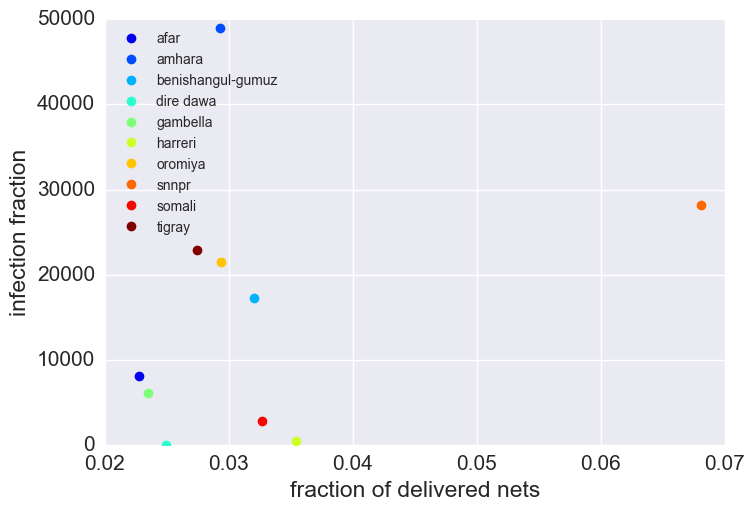

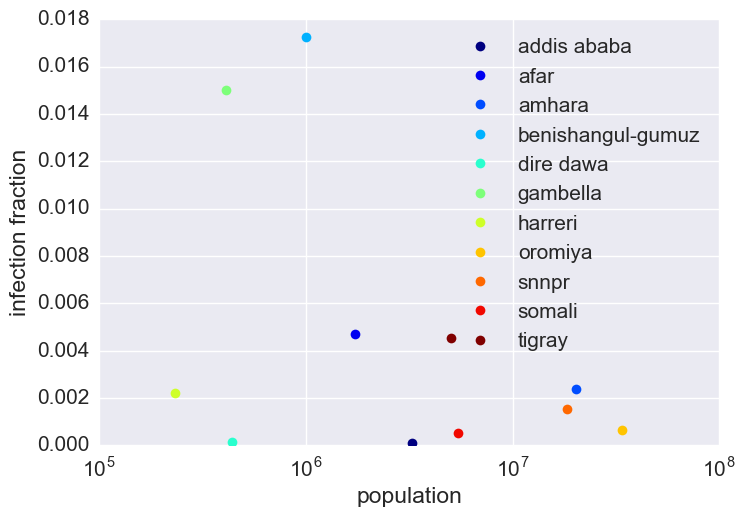

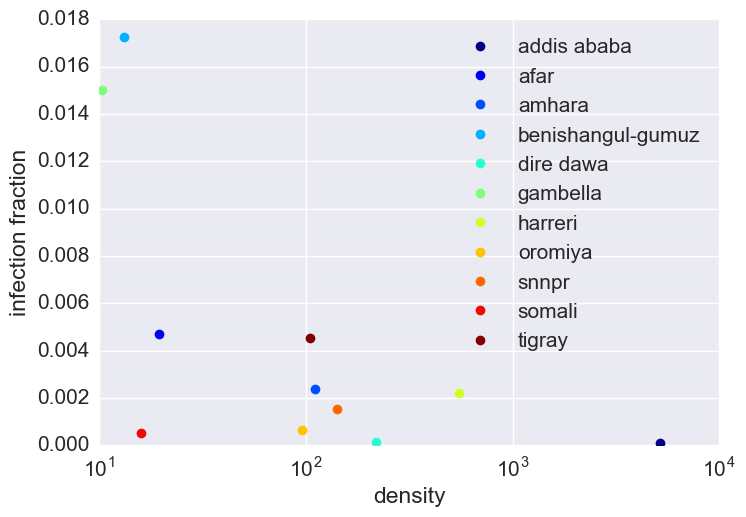

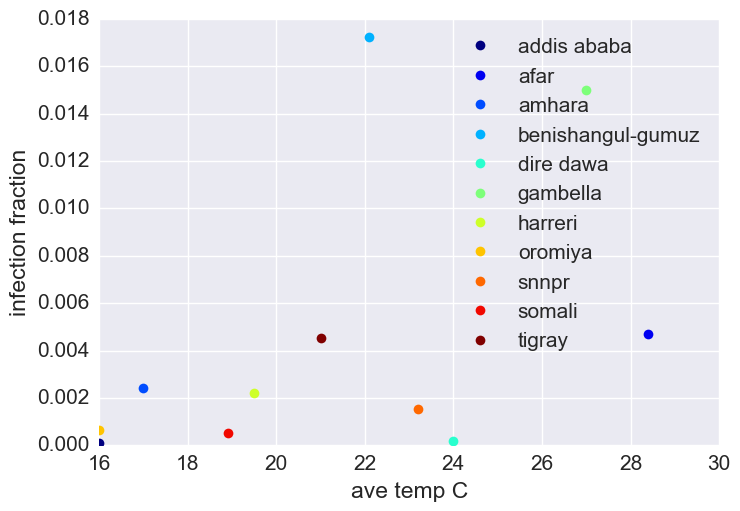

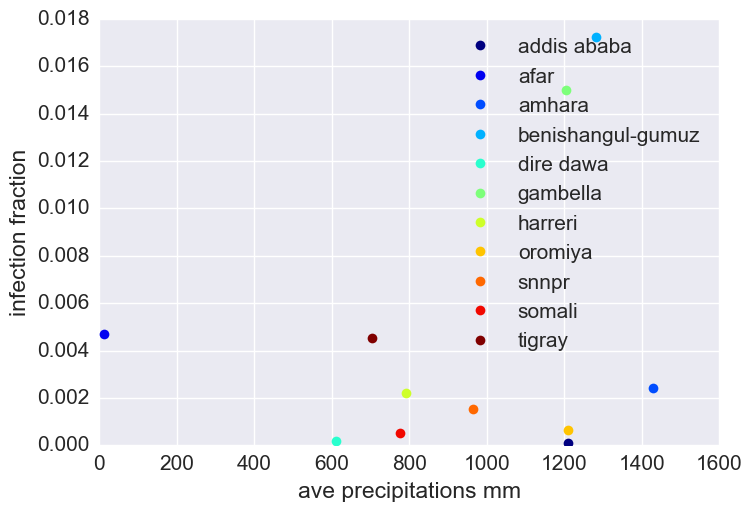

In [1740]:
start,stop=0,1
number_of_colors= len(DF_mean)
cm_subsection = linspace(start, stop, number_of_colors) 
colors = [ cm.jet(x) for x in cm_subsection ]

for region,color in zip(DF_mean.index,colors):
    if region != 'addis ababa':
        plt.plot(DF_mean_nets.loc[region]['val'], DF_mean.loc[region]['val'], 'o', color=color, label=region)
legend(fontsize=10, loc='upper left')
#xscale('log')
xlabel('fraction of delivered nets')
ylabel('infection fraction')

figure()

for region,color in zip(DF_mean.index,colors):
    plt.plot(DF_mean.loc[region]['pop'], DF_mean.loc[region]['infection_rate'], 'o', color=color, label=region)
legend()
xscale('log')
xlabel('population')
ylabel('infection fraction')

figure()
for region,color in zip(DF_mean.index,colors):
    plt.plot(DF_mean.loc[region]['density'], DF_mean.loc[region]['infection_rate'], 'o', color=color, label=region)
legend()
xscale('log')
xlabel('density')
ylabel('infection fraction')

figure()
for region,color in zip(DF_mean.index,colors):
    plt.plot(DF_mean.loc[region]['ave_temp'], DF_mean.loc[region]['infection_rate'], 'o', color=color, label=region)
legend()
#xscale('log')
xlabel('ave temp C')
ylabel('infection fraction')

figure()
for region,color in zip(DF_mean.index,colors):
    plt.plot(DF_mean.loc[region]['ave_prec_mm'], DF_mean.loc[region]['infection_rate'], 'o', color=color, label=region)
legend()
#xscale('log')
xlabel('ave precipitations mm')
ylabel('infection fraction')

<h1> Plot indicators </h1>

In [1741]:
def pd_proper_dateformat(series):
    '''Given a pandas time series return x, y with the time formatted to plot in matplotlib'''
    return series.index.astype(datetime.datetime), series.values

def frac_err(num, sig_num, den, sig_den):
    return sqrt( (sig_num / den) ** 2 + ((sig_den * num) / (den**2)) ** 2)

In [2350]:
def pd_proper_dateformat(series):
    '''Given a pandas time series return x, y with the time formatted to plot in matplotlib'''
    return series.index.astype(datetime.datetime), series.values

def plot_date_indicator(dataframe, indicator, ind2=None, val_name='val'):
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby(['Region', 'E_Date'])[val_name].sum()
    ylab_text = indicator    
    #If not none use indicator 2 as the denominator
    if ind2:
        to_plot /= dataframe.loc[dataframe['Indicator'] == ind2].reset_index().groupby(['Region', 'E_Date'])[val_name].sum()
        ylab_text = '%s per \n %s' % (indicator, ind2)
        
    start,stop=0,1
    number_of_colors= len(to_plot.index.levels[0])
    cm_subsection = linspace(start, stop, number_of_colors) 
    colors = [ cm.jet(x) for x in cm_subsection ]

    fig=figure()
    fig.set_size_inches(13, 9)
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

    for level,color in zip(to_plot.index.levels[0],colors):
        x, y = pd_proper_dateformat(to_plot[level])
        plt.plot_date(x, y, '.-', color=color, markersize=20, label=level,)
    ylabel(ylab_text)
    xlabel('Date')
    legend(loc='upper right', numpoints=1,fontsize=12)
    ax = gca()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m\n%Y'))
    #ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
    #yscale('log')
    
    return to_plot

def plot_testing(dataframe, indicator, val_name='val', pred_name = 'prediction', train_year = 2007, logscale = False, show_leg = True):
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby(['Region', 'E_Date'])[val_name].sum()
    ylab_text = indicator
    
    predict_plot = dataframe.loc[(dataframe['Indicator'] == indicator) & (dataframe['E_year'] > train_year)].reset_index().groupby(['Region', 'E_Date'])[pred_name].sum()
    pred_lab_text = pred_name
    #If not none use indicator 2 as the denominator
        
    start,stop=0,1
    number_of_colors= len(to_plot.index.levels[0])
    cm_subsection = linspace(start, stop, number_of_colors) 
    colors = [ cm.jet(x) for x in cm_subsection ]

    fig=figure()
    fig.set_size_inches(13, 9)
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

    RMSE = []
    for level,color in zip(to_plot.index.levels[0],colors):
        x, y = pd_proper_dateformat(to_plot[level])
        xp, yp = pd_proper_dateformat(predict_plot[level])
        plt.plot_date(x, y, '.-', color=color, markersize=20, label=level,)
        plt.plot_date(xp, yp, '--', color=color, markersize=20, alpha = 0.9)
        
        RMSE.append( (level, sqrt( mean((predict_plot[level] - to_plot[level])**2) ) / mean(to_plot[level]) ) ) 
        
    ylabel(ylab_text)
    xlabel('Date')
    if show_leg:
        legend(loc='upper right', numpoints=1,fontsize=12)
    ax = gca()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m\n%Y'))
    
    plt.plot_date(['%s-01-01' % (train_year+1), '%s-01-01' % (train_year+1)],[1,100000],'-', color = 'k')
    
    if logscale:
        plt.yscale('log')
        
    return RMSE

def plot_forcasting(dataframe, df_predict, indicator, val_name='val', train_year = 2007, logscale = False, show_leg = True):
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby(['Region', 'E_Date'])[val_name].sum()
    ylab_text = indicator
    
    predict_plot = df_predict.loc[(df_predict['Indicator'] == indicator) & (df_predict['E_year'] > train_year)].reset_index().groupby(['Region', 'E_Date'])['val'].sum()
    pred_lab_text = 'prediction'
    #If not none use indicator 2 as the denominator
        
    start,stop=0,1
    number_of_colors= len(to_plot.index.levels[0])
    cm_subsection = linspace(start, stop, number_of_colors) 
    colors = [ cm.jet(x) for x in cm_subsection ]

    fig=figure()
    fig.set_size_inches(13, 9)
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

    RMSE = []
    for level,color in zip(to_plot.index.levels[0],colors):
        x, y = pd_proper_dateformat(to_plot[level])
        xp, yp = pd_proper_dateformat(predict_plot[level])
        plt.plot_date(x, y, '.-', color=color, markersize=20, label=level,)
        plt.plot_date(xp, yp, '--', color=color, markersize=20, alpha = 0.9)
        
        RMSE.append( (level, sqrt( mean((predict_plot[level] - to_plot[level])**2) ) / mean(to_plot[level]) ) ) 
        
    ylabel(ylab_text)
    xlabel('Date')
    if show_leg:
        legend(loc='upper right', numpoints=1,fontsize=12)
    ax = gca()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m\n%Y'))
    
    plt.plot_date(['%s-01-01' % (train_year+1), '%s-01-01' % (train_year+1)],[1,100000],'-', color = 'k')
    
    if logscale:
        plt.yscale('log')
        
    return RMSE

def plot_testing_nation(dataframe, indicator, val_name='val', pred_name = 'prediction', train_year = 2007):
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby(['E_Date'])[val_name].sum()
    ylab_text = indicator
    
    predict_plot = dataframe.loc[(dataframe['Indicator'] == indicator) & (dataframe['E_year'] > train_year)].reset_index().groupby(['E_Date'])[pred_name].sum()
    pred_lab_text = pred_name
    #If not none use indicator 2 as the denominator

    fig=figure()
    fig.set_size_inches(13, 9)
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

    plt.subplot2grid((4,1), (0,0), rowspan=3)
    x, y = pd_proper_dateformat(to_plot)
    xp, yp = pd_proper_dateformat(predict_plot)
    plt.plot_date(x, y, '.-', color='k', markersize=20, label='National Average',)
    plt.plot_date(xp, yp, '--', color='k', markersize=20, label='Prediction', alpha = 0.7)
        
    ylabel(ylab_text)
    #xlabel('Date')
    legend(loc='upper right', numpoints=1,fontsize=12)
    ax = gca()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
    
    plt.plot_date(['%s-01-01' % (train_year+1), '%s-01-01' % (train_year+1)],[1,300000],'-', color = 'k')
    
    # Plot error 
    
    plt.subplot2grid((4,1), (3,0))
    
    #RMSE_n = mean(sqrt((predict_plot - to_plot)**2) / to_plot)
    RMSE_n = sqrt( mean((predict_plot - to_plot)**2) ) / mean(to_plot)
    x, y = pd_proper_dateformat( ((predict_plot - to_plot) * 100 / to_plot).replace(nan,0) )

    plt.plot_date(x, y, '.', color='k', markersize=20, label='percent error',)
    #legend(loc='upper right', numpoints=1,fontsize=12)
    #plt.text(max(x), max(y), 'Norm RMSE = %s' % RMSE_n *100)
    
    ylabel('Percent Error')
    ax = gca()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
    xlabel('Date')
    
    return to_plot, predict_plot, RMSE_n
    

def plot_forcast_nation(dataframe, df_predict, indicator, val_name='val', train_year = 2007, res=True):
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby(['E_Date'])[val_name].sum()
    ylab_text = indicator
    
    predict_plot = df_predict.loc[(df_predict['Indicator'] == indicator) & (df_predict['E_year'] > train_year)].reset_index().groupby(['E_Date'])['val'].sum()
    pred_lab_text = 'prediction'
    #If not none use indicator 2 as the denominator

    fig=figure()
    fig.set_size_inches(13, 9)
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

    if res:
        plt.subplot2grid((4,1), (0,0), rowspan=3)
    x, y = pd_proper_dateformat(to_plot)
    xp, yp = pd_proper_dateformat(predict_plot)
    plt.plot_date(x, y, '.-', color='k', markersize=20, label='National Average',)
    plt.plot_date(xp, yp, '--', color='k', markersize=20, label='Prediction', alpha = 0.7)
        
    ylabel(ylab_text)
    #xlabel('Date')
    legend(loc='upper right', numpoints=1,fontsize=12)
    ax = gca()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
    
    plt.plot_date(['%s-01-01' % (train_year+1), '%s-01-01' % (train_year+1)],[1,300000],'-', color = 'k')
    
    # Plot residual errors
    if res:
        plt.subplot2grid((4,1), (3,0))

        #RMSE_n = mean(sqrt((predict_plot - to_plot)**2) / to_plot)
        RMSE_n = sqrt( mean((predict_plot - to_plot)**2) ) / mean(to_plot)
        x, y = pd_proper_dateformat( ((predict_plot - to_plot) * 100 / to_plot).replace(nan,0) )

        plt.plot_date(x, y, '.', color='k', markersize=20, label='percent error',)
        #legend(loc='upper right', numpoints=1,fontsize=12)
        #plt.text(max(x), max(y), 'Norm RMSE = %s' % RMSE_n *100)

        ylabel('Percent Error')
        ax = gca()
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
        xlabel('Date')
    
    return to_plot, predict_plot, RMSE_n
    
    
def plot_date_indicator_nation(dataframe, indicator, val_name='val', ind2=None, plt_err=False, plt_mean=False, plt_mean_std=False, x_range=[0,-1]):
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby(['E_Date'])[val_name].sum()
    to_plot = to_plot[x_range[0]:x_range[1]]
    yn = to_plot.values
    sqrtNn = sqrt(yn)
    y_err = sqrtNn
    ylab_text = indicator
    #If not none use indicator 2 as the denominator
    if ind2:
        to_plot_d = dataframe.loc[dataframe['Indicator'] == ind2].reset_index().groupby(['E_Date'])[val_name].sum()
        to_plot /= to_plot_d
        yt = to_plot_d.values
        sqrtNt = sqrt(yt)
        y_err = frac_err(yn, sqrtNn, yt, sqrtNt)
        #use binomial error
        p = to_plot.values
        y_err = sqrt( p*(1-p) / yt )
        ylab_text = '%s per \n %s' % (indicator, ind2)
    
    
    fig=figure()
    fig.set_size_inches(13, 9)
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    x, y = pd_proper_dateformat(to_plot)
    y_mean = ones_like(y)*mean(y)
    y_mean_err = std(y) / sqrt(len(y))
    plt.plot_date(x, y, '.-', color='k', markersize=20, label='Nation',)
    
    if plt_err:
        plt.fill_between(x, y-y_err, y+y_err,
            alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
            linewidth=4, linestyle='dashdot', antialiased=True, label=r'1 $\sigma$')
        
    if plt_mean:
        plt.plot_date(x, y_mean, '-', color='k', markersize=20, label='Mean',)
    if plt_mean_std:    
        plt.fill_between(x, y_mean-y_mean_err, y_mean+y_mean_err,
        alpha=0.2, edgecolor='black', facecolor='grey',
        linewidth=4, linestyle='dashdot', antialiased=True)
    
    #x has to be in int to fit the data
    x_fit = to_plot.index.astype(int)
    fit = np.poly1d(np.polyfit(x_fit, y, 1))
    y_lin = fit(x_fit)
    plt.plot_date(x, y_lin,'-', color='r', label='Liner Fit',)
    
    ylabel(ylab_text)
    xlabel('Date')
    legend(loc='upper right', numpoints=1,fontsize=12)
    ax = gca()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m\n%Y'))
    
    return to_plot


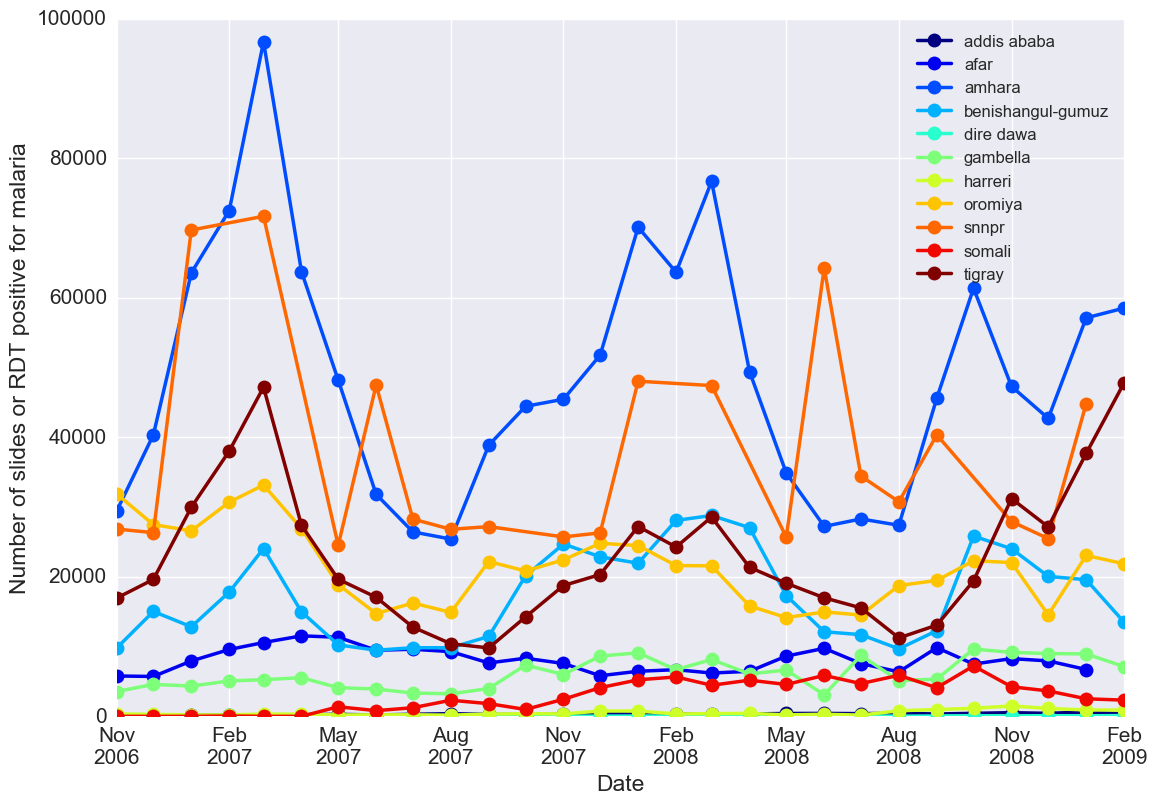

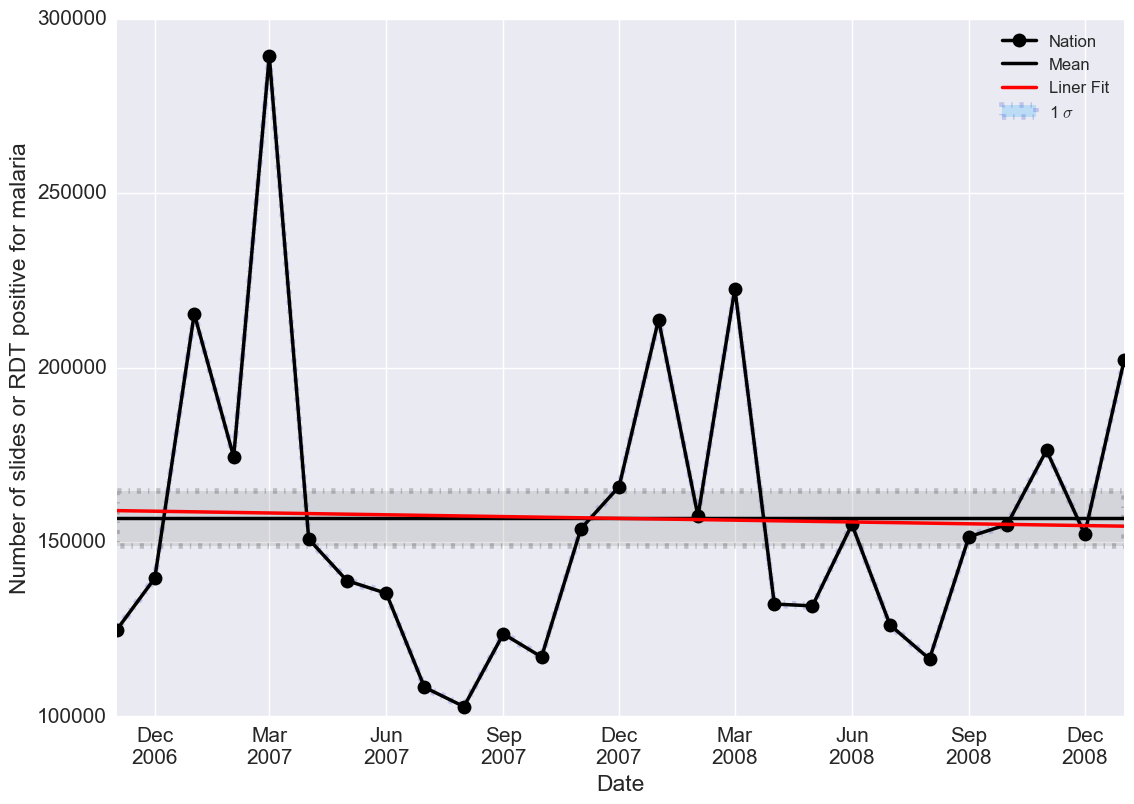

In [1743]:
indicator = 'Number of slides or RDT positive for malaria'
series_d = plot_date_indicator(DF_ind, indicator)
series_d = plot_date_indicator_nation(DF_ind, indicator, plt_mean=True, plt_err=True, plt_mean_std=True, x_range=[0,-1])

In [1103]:
range_cut = (DF_ind['E_year']>2006) & (DF_ind['E_year']<2009)
DF_pdf = DF_ind.loc[range_cut]
year_sum = DF_pdf.groupby(['E_year']).val.sum()

In [1104]:
year_sum

E_year
2007    1.213063e+07
2008    2.200465e+07
Name: val, dtype: float64

<h3> number of malaria cases are slighly trending up </h3>

In [1105]:
DF_pdf['year_pdf'] = DF_pdf['val']/[year_sum[year] for year in DF_pdf['E_year']]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


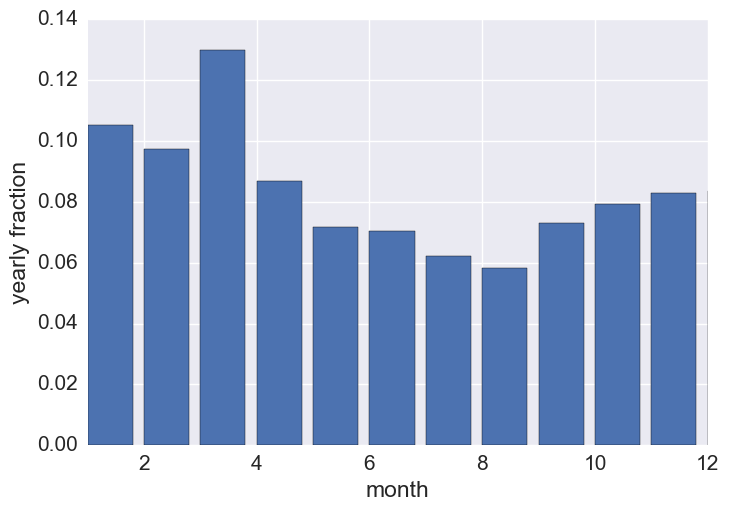

In [2341]:
indicator = 'Number of slides or RDT positive for malaria'
#can do M/F profile also
monthly = DF_ind.loc[DF_ind['Indicator'] == indicator].groupby('E_month').val.mean()
plt.bar(monthly.index, monthly.values/ sum(monthly.values))
xlim(1,12)
xlabel('month')
ylabel('yearly fraction')

<h1> Load in weather data </h1>

In [1107]:
DF_weather = pd.read_excel('/Users/attiladobi/Documents/Ethiopia_weather.xlsx', header=1).dropna(how='all').set_index(['city','Field'])

(array([ 32.,   1.,   0.,   0.,   2.,   2.,   1.,   0.,   3.,   1.]),
 array([    8. ,   150.2,   292.4,   434.6,   576.8,   719. ,   861.2,
         1003.4,  1145.6,  1287.8,  1430. ]),
 <a list of 10 Patch objects>)

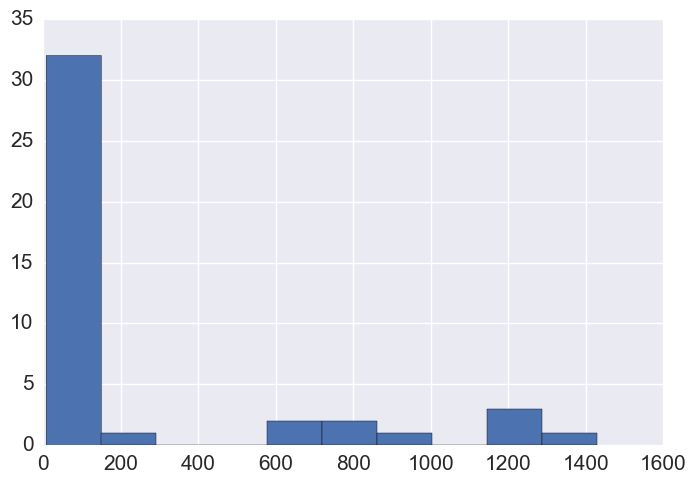

In [192]:
plt.hist(DF_weather['ANNUAL'].dropna().values)

<h3> Temperature distribution </h3>

15.0 32.0


(array([  5.,   7.,  12.,   4.,   5.,   8.,  15.,   9.,   9.,   2.,   9.,
         11.,   5.,   6.,   1.,   4.,   3.,   2.,   0.,   3.]),
 array([ 15.  ,  15.85,  16.7 ,  17.55,  18.4 ,  19.25,  20.1 ,  20.95,
         21.8 ,  22.65,  23.5 ,  24.35,  25.2 ,  26.05,  26.9 ,  27.75,
         28.6 ,  29.45,  30.3 ,  31.15,  32.  ]),
 <a list of 20 Patch objects>)

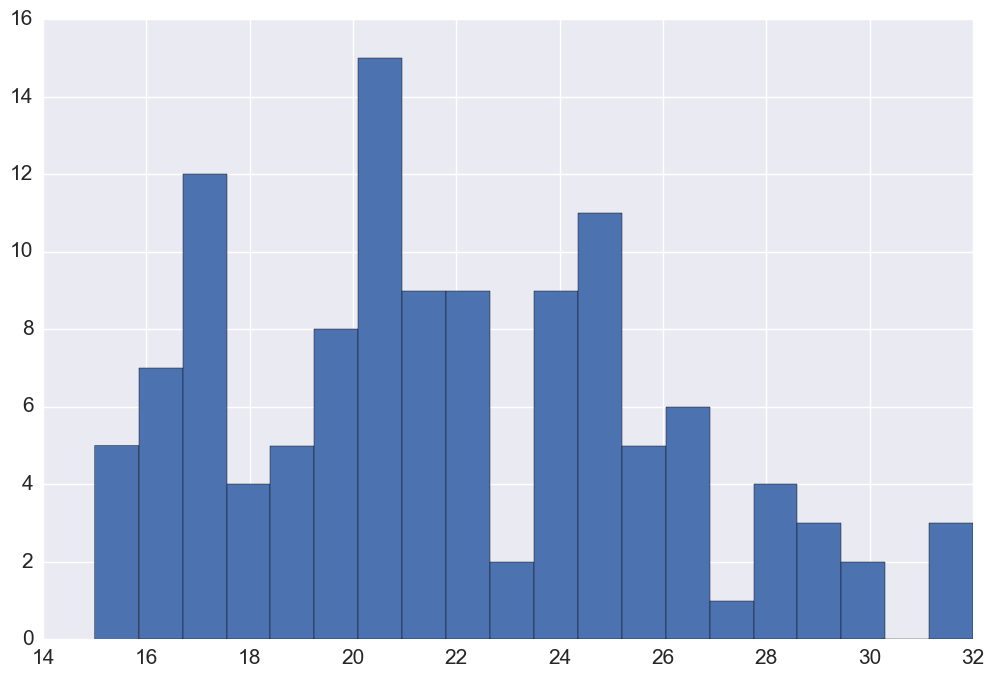

In [307]:
AA = DF_weather.drop('ANNUAL',1).replace(nan,0).reset_index()
AA = AA.loc[AA['Field'] == 'temp'].set_index('city').drop('Field',1)
all_data = [val for sub in AA.values for val in sub]
print min(all_data) , max(all_data)
plt.hist(all_data,20)

In [955]:
DF_weather

ANNUAL   JAN   FEB   MAR    APR    MAY    JUN    JUL  \
city        Field                                                             
Asosa       temp         22.1  21.4  22.8  24.5   25.1   23.8   21.6   20.3   
            prec_mm    1281.8   0.7   4.5  20.8   58.0  126.5  198.7  240.9   
            prec_days    89.2   1.7   2.3   3.4    5.2    8.9   12.8   15.1   
            rel_hum      51.1  33.0  28.9  29.7   36.6   52.1   62.5   73.2   
            dew_c        11.5   4.5   3.8   5.6    9.2   13.4   14.1   15.3   
Semera      temp         28.4  24.7  25.6  27.3   28.8   30.2   32.0   31.9   
            prec_mm      11.5   7.4   7.3  28.9   22.6   11.1    4.8   46.4   
            prec_days    29.4   1.2   1.2   1.3    2.0    2.9    3.9    4.1   
            rel_hum      70.6  70.3  69.0  69.3   71.7   72.8   66.7   64.9   
            dew_c        22.5  18.9  19.5  21.2   23.2   24.8   25.0   24.5   
Bahir Dar   temp         17.0  15.0  17.0  20.0   20.0   20.0   19.0   17.0   
            prec_mm    1430.0   3.0   1.0   8.0   25.0   83.0  182.0  434.0   
            prec_days     NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN   
            rel_hum       NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN   
            dew_c         NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN   
Addis Ababa temp         16.0  16.0  17.0  17.0   17.0   18.0   17.0   15.0   
            prec_mm    1210.0  10.0  30.0  60.0   80.0   80.0  130.0  260.0   
            prec_days     NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN   
            rel_hum      84.0  81.0  80.0  79.0   82.0   81.0   85.0   92.0   
            dew_c         8.0   6.0   7.0   8.0    9.0    8.0   10.0   11.0   
Dire Dawa   temp         24.0  21.0  22.0  24.0   25.0   26.0   28.0   25.0   
            prec_mm     610.0  20.0  40.0  50.0   80.0   10.0   30.0   80.0   
            prec_days    45.0   2.0   4.0   4.0    6.0    1.0    2.0    6.0   
            rel_hum      62.0  66.0  69.0  65.0   64.0   58.0   56.0   59.0   
            dew_c        16.0  14.0  15.0  17.0   17.0   16.0   17.0   15.0   
Gambela     temp         27.0  26.7  28.0  29.3   29.2   27.8   26.4   25.5   
            prec_mm    1204.9   6.5  10.1  29.6   62.6  148.1  160.8  230.3   
            prec_days    72.2   1.0   1.7   3.2    5.0    7.5   10.3   11.9   
            rel_hum      54.6  35.5  32.3  36.2   45.8   59.2   66.1   72.6   
            dew_c        17.1  10.2   9.9  12.8   16.3   19.1   19.6   20.2   
Harar       temp         19.5  17.1  18.4  19.9   20.6   21.6   21.9   20.8   
            prec_mm     791.2  19.7  28.0  59.4   94.9  102.3   65.2  108.7   
            prec_days    63.8   1.8   2.4   3.7    6.8    7.9    8.4    6.5   
            rel_hum      66.9  60.4  62.8  64.7   71.2   73.2   66.2   63.4   
            dew_c        13.2   9.4  11.2  13.1   15.2   16.6   15.3   13.6   
Jijiga      temp         18.9  16.6  17.8  19.2   19.8   20.8   20.9   20.3   
            prec_mm     776.4  11.2  29.3  50.7  105.8  101.6   56.6   94.1   
            prec_days    58.5   1.5   1.9   3.3    6.0    7.3    8.1    6.0   
            rel_hum      68.5  63.7  66.3  67.9   73.7   74.9   66.9   62.7   
            dew_c        13.0   9.7  11.4  13.1   15.0   16.2   14.5   13.0   
Hawassa     temp         23.2  24.0  24.5  25.0   24.5   23.5   22.0   21.5   
            prec_mm     965.0  30.0  45.0  65.0  100.0  120.0  105.0  130.0   
            prec_days   163.0   6.0   9.0  14.0   17.0   17.0   16.0   20.0   
            rel_hum       NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN   
            dew_c         NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN   
Mek'ele     temp         21.0  19.5  20.5  21.5   22.5   23.5   23.5   20.5   
            prec_mm     705.0  35.0  10.0  25.0   45.0   35.0   30.0  200.0   
            prec_days    85.0   4.0   1.0   4.0    5.0    4.0    6.0   22.0   
            rel_hum       NaN   NaN   NaN   NaN    NaN    NaN    NaN    N

<h3> Precipitation distribution </h3>

0.0 434.0


(array([ 30.,  14.,  13.,  10.,   7.,   6.,   4.,   9.,   6.,   2.,   2.,
          2.,   2.,   2.,   3.,   2.,   2.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([   0.        ,   14.46666667,   28.93333333,   43.4       ,
          57.86666667,   72.33333333,   86.8       ,  101.26666667,
         115.73333333,  130.2       ,  144.66666667,  159.13333333,
         173.6       ,  188.06666667,  202.53333333,  217.        ,
         231.46666667,  245.93333333,  260.4       ,  274.86666667,
         289.33333333,  303.8       ,  318.26666667,  332.73333333,
         347.2       ,  361.66666667,  376.13333333,  390.6       ,
         405.06666667,  419.53333333,  434.        ]),
 <a list of 30 Patch objects>)

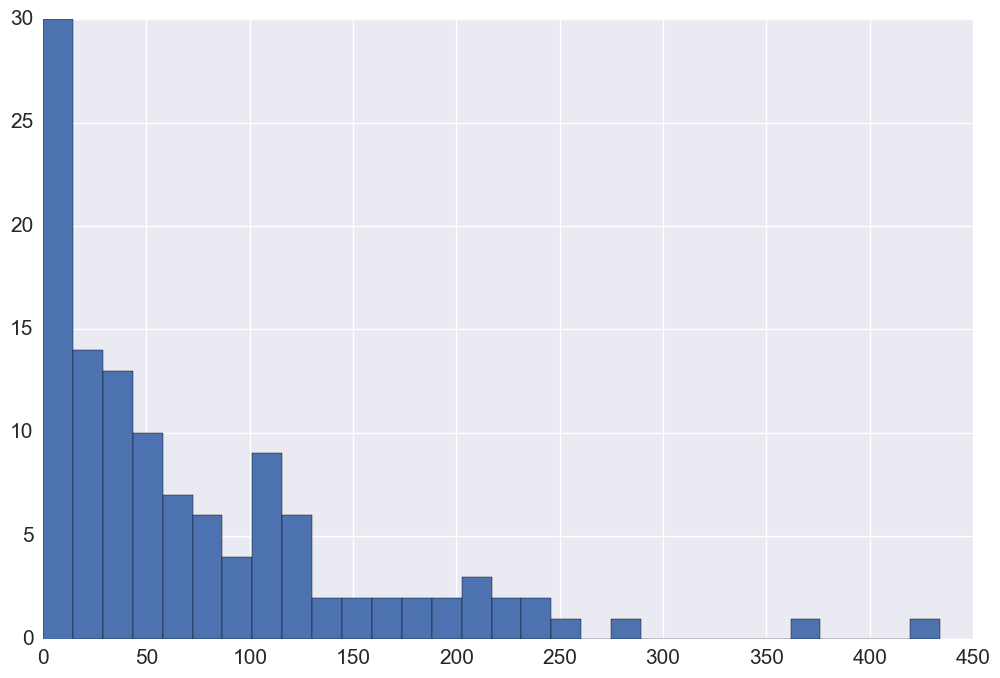

In [309]:
AA = DF_weather.drop('ANNUAL',1).replace(nan,0).reset_index()
AA = AA.loc[AA['Field'] == 'prec_mm'].set_index('city').drop('Field',1)
all_data = [val for sub in AA.values for val in sub]
print min(all_data) , max(all_data)
plt.hist(all_data,30)

<h1> Add weather data and catagorize them</h1>

In [1797]:
def temp_map(temp):
    if temp < 20:
        return 0
    elif (temp >= 20) & (temp < 30):
        return 1
    elif (temp >= 25) & (temp < 30):
        return 2
    else:
        return 3
    
def prec_map(precip):
    if precip < 20:
        return 0
    elif (precip >= 20) & (precip < 50):
        return 1
    elif (precip >= 55) & (precip < 100):
        return 2
    else:
        return 3
    
def map_elevation(elev):
    if elev < 1000:
        return 0
    if elev >=1000 and elev < 1700:
        return 1
    else: 
        return 2

In [2225]:
month_map = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6, 'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12 }
inv_month_map = {v: k for k, v in month_map.iteritems()}

In [2227]:
DF_ind['temp'] = [DF_weather.loc[capital,'temp'][inv_month_map[month]] for capital,month in zip(DF_ind['capital'],DF_ind['month'])]
DF_ind['prec_mm'] = [DF_weather.loc[capital,'prec_mm'][inv_month_map[month]] for capital,month in zip(DF_ind['capital'],DF_ind['month'])]
DF_ind['prec_mm'] = DF_ind['prec_mm'].replace(nan,0)

DF_ind['temp_cat'] = [temp_map(temp) for temp in DF_ind['temp']]
DF_ind['prec_cat'] = [prec_map(prec) for prec in DF_ind['prec_mm']]

<h1> For prediction only use one indicator "number testing positive for malaria" </h1>

In [2228]:
indicator = 'Number of slides or RDT positive for malaria'
indicator_cut = [ind_name in set(ind_names) for ind_name in DF_ind['Indicator']]

#build a new dataframe from the indicator cut on the original one
#DF_shift = pd.DataFrame(DF_ind.loc[DF_ind['Indicator'].isin set(ind_names)])

DF_shift = pd.DataFrame(DF_ind.loc[indicator_cut])

<h1> add leading indicators </h1>

In [2432]:
#DF_shift['val'] = DF_shift['val'] / DF_shift['val'].max()
DF_shift['val_shift_1'] = DF_shift.shift(1)['val']
#DF_shift['val_delta'] = (DF_shift['val'] - DF_shift['val_shift_1']) / DF_shift['val_shift_1']
DF_shift['infection_rate_shift_1'] = DF_shift.shift(1)['infection_rate']
DF_shift['temp_shift_1'] = DF_shift.shift(1)['temp']
DF_shift['temp_cat_shift_1'] = DF_shift.shift(1)['temp_cat']
DF_shift['prec_shift_1'] = DF_shift.shift(1)['prec_mm']
DF_shift['prec_cat_shift_1'] = DF_shift.shift(1)['prec_cat']
DF_shift['Region_shift_1'] = DF_shift.shift(1)['Region']
DF_shift['Ind_shift_1'] = DF_shift.shift(1)['Indicator']

#only makes sense when considering historical averages
DF_shift['temp_delta'] = DF_shift['temp'] - DF_shift['temp_shift_1']
DF_shift['prec_delta'] = DF_shift['prec_mm'] - DF_shift['prec_shift_1']

DF_shift['val_shift_2'] = DF_shift.shift(2)['val']
DF_shift['infection_rate_shift_2'] = DF_shift.shift(2)['infection_rate']
DF_shift['temp_shift_2'] = DF_shift.shift(2)['temp']
DF_shift['temp_cat_shift_2'] = DF_shift.shift(2)['temp_cat']
DF_shift['prec_shift_2'] = DF_shift.shift(2)['prec_mm']
DF_shift['prec_cat_shift_2'] = DF_shift.shift(2)['prec_cat']
DF_shift['Region_shift_2'] = DF_shift.shift(2)['Region']
DF_shift['Ind_shift_2'] = DF_shift.shift(2)['Indicator']

DF_shift['temp_delta_2'] = DF_shift['temp_shift_1'] - DF_shift['temp_shift_2']
DF_shift['prec_delta_2'] = DF_shift['prec_shift_1'] - DF_shift['prec_shift_2']

#val delta can not rely on the upcoming prediction. Only makes sense to go two back
DF_shift['val_delta'] = (DF_shift['val_shift_1'] - DF_shift['val_shift_2']) / DF_shift['val_shift_2']
DF_shift['infection_rate_delta'] = (DF_shift['infection_rate_shift_1'] - DF_shift['infection_rate_shift_2']) / DF_shift['infection_rate_shift_2']

<h1> log scale </h1>

In [2230]:
DF_shift['log_val'] = np.log10(DF_shift['val']).replace(nan, 1/100)
DF_shift['log_val_delta'] = np.log10(DF_shift['val_delta']).replace(nan, 1/100).replace(-inf, 1/1000)
DF_shift['log_val_shift_1'] = np.log10(DF_shift['val_shift_1']).replace(nan, 1/100).replace(-inf, 1/1000)
DF_shift['log_val_shift_2'] = np.log10(DF_shift['val_shift_2']).replace(nan, 1/100).replace(-inf, 1/1000)

DF_shift['log_infection_rate'] = np.log10(DF_shift['infection_rate']).replace(nan, 1/100).replace(-inf, 1/1000)
DF_shift['log_infection_rate_shift_1'] = np.log10(DF_shift['infection_rate_shift_1']).replace(nan, 1/100).replace(-inf, 1/1000)

DF_shift['log_elevation_m'] = np.log10(DF_shift['elevation_m']).replace(nan, 1/100)
DF_shift['log_pop'] = np.log10(DF_shift['pop']).replace(nan, 1/100)
DF_shift['log_density'] = np.log10(DF_shift['density']).replace(nan, 1/100)

DF_shift['log_prec_mm'] = np.log10(DF_shift['prec_mm']).replace(nan, 1/100).replace(-inf, 1/1000)
DF_shift['log_prec_shift_1'] = np.log10(DF_shift['prec_shift_1']).replace(nan, 1/100).replace(-inf, 1/1000)
DF_shift['log_prec_shift_2'] = np.log10(DF_shift['prec_shift_2']).replace(nan, 1/100).replace(-inf, 1/1000)

DF_shift['log_prec_delta'] = np.log10(DF_shift['prec_delta']).replace(nan, 1/100).replace(-inf, 1/1000)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in log10


<h3> clean up nan and region missmatch. Require the region and the indicator to be the same </h3>

In [2433]:
DF_shift = DF_shift.loc[(DF_shift['Region'] == DF_shift['Region_shift_1']) &\
                      (DF_shift['Indicator'] == DF_shift['Ind_shift_1']) &\
                      (DF_shift['Region'] == DF_shift['Region_shift_2']) &\
                      (DF_shift['Indicator'] == DF_shift['Ind_shift_2']) ]


In [2426]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from sklearn.preprocessing import OneHotEncoder
RF = RandomForestRegressor()
RF = GradientBoostingRegressor()


In [2434]:
y = DF_shift.infection_rate.values


features = ['pop','density','month', 'net_frac', 'elevation_m', 'temp', 'prec_mm', 'temp_delta', 'prec_delta', \
        'val_delta', 'gen_cat', 'age_cat', 'infection_rate_shift_1', 'infection_rate_shift_2', 'infection_rate_delta',\
        'val_shift_1', 'temp_cat_shift_1', 'prec_cat_shift_1','val_shift_2', 'temp_cat_shift_2', 'prec_cat_shift_2']

#log_features = ['log_pop','log_density','month', 'net_frac', 'log_elevation_m', 'temp', 'log_prec_mm', 'temp_delta',\
#            'log_prec_delta', 'log_val_delta', 'gen_cat', 'age_cat', \
#            'log_infection_rate_shift_1', 'log_val_shift_1', 'log_val_delta',\
#            'temp_shift_1', 'log_prec_shift_1','log_val_shift_2', 'temp_shift_2', 'log_prec_shift_2']


x = DF_shift[features].values

RF.fit(x,y)

print RF.feature_importances_

prediction = [RF.predict(val) for val in x]

DF_shift['prediction'] = [val[0] for val in prediction]

[ 0.          0.01181972  0.03229191  0.00361755  0.          0.08166534
  0.07907938  0.04059193  0.05442488  0.035756    0.01014287  0.02239119
  0.34756719  0.20038994  0.04229131  0.01135453  0.00383338  0.00189033
  0.02046918  0.          0.00042338]


/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/lo

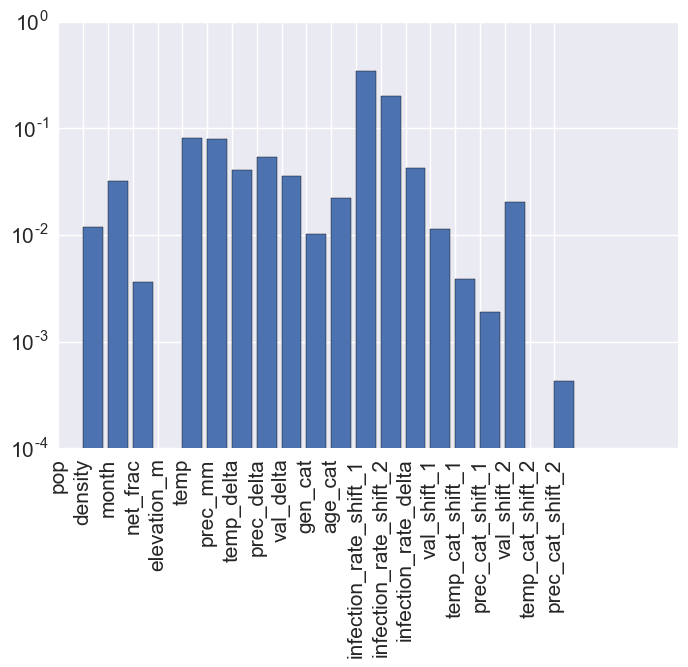

In [2435]:
#features = ['pop','density','month', 'net_frac', 'elevation_m', 'temp_cat', 'prec_cat', 'temp_delta', 'prec_delta', \
#            'val_delta', 'gen_cat', 'age_cat', 'infection_rate_shift_1', 'val_shift_1', 'temp_cat_shift_1', 'prec_cat_shift_1',\
#             'val_shift_2', 'temp_cat_shift_2', 'prec_cat_shift_2']
x = range(len(RF.feature_importances_))
plt.bar(x, RF.feature_importances_)
xticks(x, features, rotation = 'vertical')
yscale('log')

In [2643]:
indicator = 'Number of slides or RDT positive for malaria'
series_d = plot_date_indicator(DF_ind, indicator, val_name='infection_rate')
series_p = plot_date_indicator(DF_shift, indicator, val_name='prediction')

KeyError: 'E_Date'

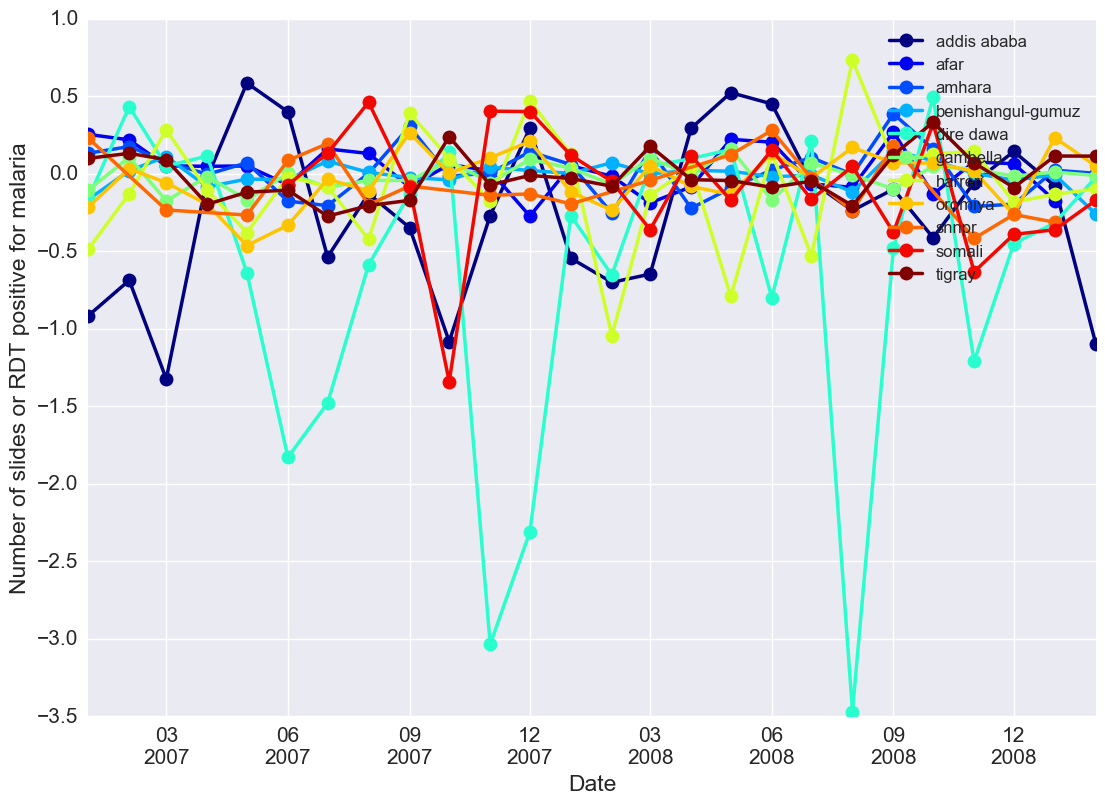

In [2430]:
DF_shift['diff'] = DF_shift['infection_rate']-DF_shift['prediction']
DF_shift['norm_diff'] = (DF_shift['infection_rate']-DF_shift['prediction']) / DF_shift['infection_rate']
series_d = plot_date_indicator(DF_shift, indicator, val_name='norm_diff')

In [2431]:
sqrt(mean((DF_shift['infection_rate']-DF_shift['prediction'])**2))

0.00034646654779721468

<h1> predicting the values </h1>

In [2637]:
y = DF_shift.val.values

features = ['pop','density','month', 'elevation_m', 'net_frac', 'temp', 'prec_mm', 'temp_delta', 'prec_delta', \
              'val_delta', 'val_shift_1', 'temp_shift_1', 'prec_shift_1', \
              'val_shift_2', 'temp_shift_2', 'prec_shift_2', 'gen_cat', 'age_cat']

#features_log = ['log_pop','log_density','month', 'net_frac', 'log_elevation_m', 'temp', 'log_prec_mm', 'temp_delta',\
#            'log_prec_delta', 'log_val_delta', 'gen_cat', 'age_cat', \
#            'log_infection_rate_shift_1', 'log_val_shift_1', 'log_val_delta',\
#            'temp_shift_1', 'log_prec_shift_1','log_val_shift_2', 'temp_shift_2', 'log_prec_shift_2']

x = DF_shift[features].values
# 'net_frac', 'val_shift_2', 'temp_cat_shift_2', 'prec_cat_shift_2'

RF.fit(x,y)

#print RF.feature_importances_

prediction = [RF.predict(val) for val in x]

DF_shift['prediction'] = [val[0] for val in prediction]


/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/lo

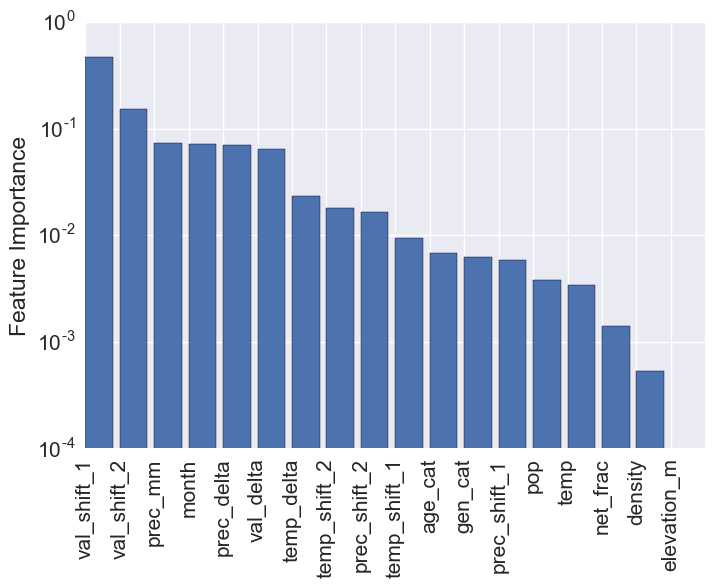

In [2641]:
feature_imp = RF.feature_importances_
sorted_index = sorted(range(len(feature_imp)),key=lambda x:feature_imp[x], reverse=True)

x = range(len(RF.feature_importances_))
plt.bar(x, feature_imp[sorted_index])
xticks(x, [features[i] for i in sorted_index], rotation = 'vertical')
yscale('log')
ylabel('Feature Importance')

In [2642]:
indicator = 'Number of slides or RDT positive for malaria'
series_d = plot_date_indicator(DF_ind, indicator, val_name='val')
series_p = plot_date_indicator(DF_shift, indicator, val_name='prediction')

KeyError: 'E_Date'

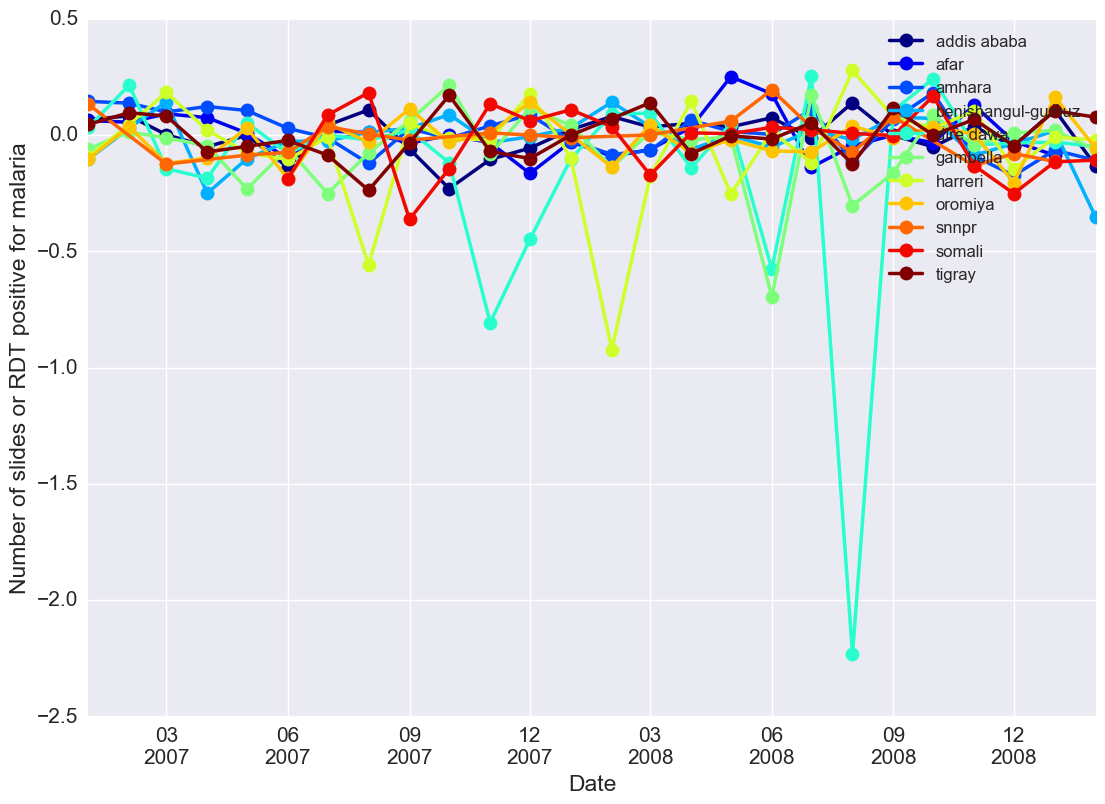

In [2244]:
DF_shift['diff'] = DF_shift['val']-DF_shift['prediction']
DF_shift['norm_diff'] = (DF_shift['val']-DF_shift['prediction']) / DF_shift['val']
DF_shift['mse'] = (DF_shift['val']-DF_shift['prediction']) ** 2
series_d = plot_date_indicator(DF_shift, indicator, val_name='norm_diff')

In [2363]:
sqrt(mean((DF_shift['val']-DF_shift['prediction'])**2))

873.92158206017496

In [2364]:
sqrt(DF_shift.groupby('Region').mse.mean())/DF_shift.groupby('Region').val.mean()*100

Region
addis ababa          17.176558
afar                 13.150506
amhara               17.744690
benishangul-gumuz    14.889624
dire dawa            37.926506
gambella             18.043106
harreri              28.417860
oromiya              13.952390
snnpr                10.116498
somali               17.550388
tigray               16.930858
dtype: float64

In [2170]:
ind_names

['Number of slides or RDT positive for malaria',
 'Number of slides or RDT positive for malaria < 5 years: Females',
 'Number of slides or RDT positive for malaria < 5 years: Males',
 'Number of slides or RDT positive for malaria 5-14 years: Females',
 'Number of slides or RDT positive for malaria 5-14 years: Males',
 'Number of slides or RDT positive for malaria >=15 years: Females',
 'Number of slides or RDT positive for malaria >=15 years: Males']

In [2240]:
DF_ind.loc[DF_ind['Indicator']=='Number of slides or RDT positive for malaria >=15 years: Males'].val.mean() / \
DF_ind.loc[DF_ind['Indicator']=='Number of slides or RDT positive for malaria >=15 years: Females'].val.mean()

DF_ind.loc[DF_ind['Indicator']=='Number of slides or RDT positive for malaria 5-14 years: Males'].val.mean() / \
DF_ind.loc[DF_ind['Indicator']=='Number of slides or RDT positive for malaria 5-14 years: Females'].val.mean()

DF_ind.loc[DF_ind['Indicator']=='Number of slides or RDT positive for malaria < 5 years: Males'].val.mean() / \
DF_ind.loc[DF_ind['Indicator']=='Number of slides or RDT positive for malaria < 5 years: Females'].val.mean()

1.2192850167173694

<h1> Simplified model </h1> 

In [2370]:
#train on 2007 data
DF_training = pd.DataFrame(DF_shift.loc[DF_shift['E_year'] < 2009])

#all data
DF_training = DF_shift

In [2371]:
y = DF_training.val.values

features = ['density','month', 'elevation_m', 'temp', 'prec_mm', 'temp_delta', 'prec_delta', \
              'val_delta', 'val_shift_1', 'temp_shift_1', 'prec_shift_1', \
              'val_shift_2', 'temp_shift_2', 'prec_shift_2', 'gen_cat', 'age_cat']

#features = ['pop','density','month', 'elevation_m', 'net_frac', 'temp', 'prec_mm', 'temp_delta', 'prec_delta', \
#              'val_delta', 'val_shift_1', 'temp_shift_1', 'prec_shift_1', \
#              'val_shift_2', 'temp_shift_2', 'prec_shift_2', 'gen_cat', 'age_cat']


x = DF_training[features].values
# 'net_frac', 'val_shift_2', 'temp_cat_shift_2', 'prec_cat_shift_2'

x_all = DF_shift[features].values


RF.fit(x,y)


prediction = [RF.predict(val) for val in x_all]

DF_shift['prediction'] = [val[0] for val in prediction]



[  4.82134693e-04   2.39123851e-03   1.36469777e-03   2.26863287e-03
   2.99095988e-03   1.93420508e-03   1.87993739e-02   8.17059445e-03
   9.32670205e-01   2.81630229e-03   4.72495891e-03   4.32106348e-03
   1.79225934e-03   1.32206887e-02   6.68234921e-04   1.38445045e-03]


/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/lo

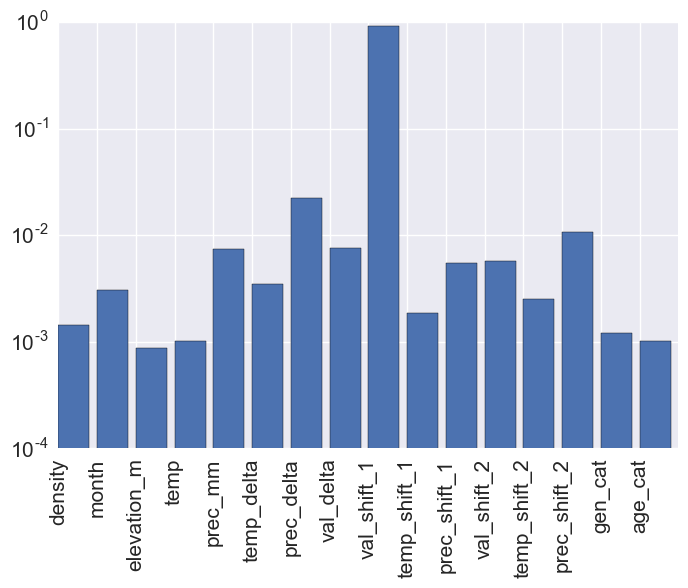

In [2355]:
x = range(len(RF.feature_importances_))
plt.bar(x, RF.feature_importances_)
xticks(x, features, rotation = 'vertical')
yscale('log')

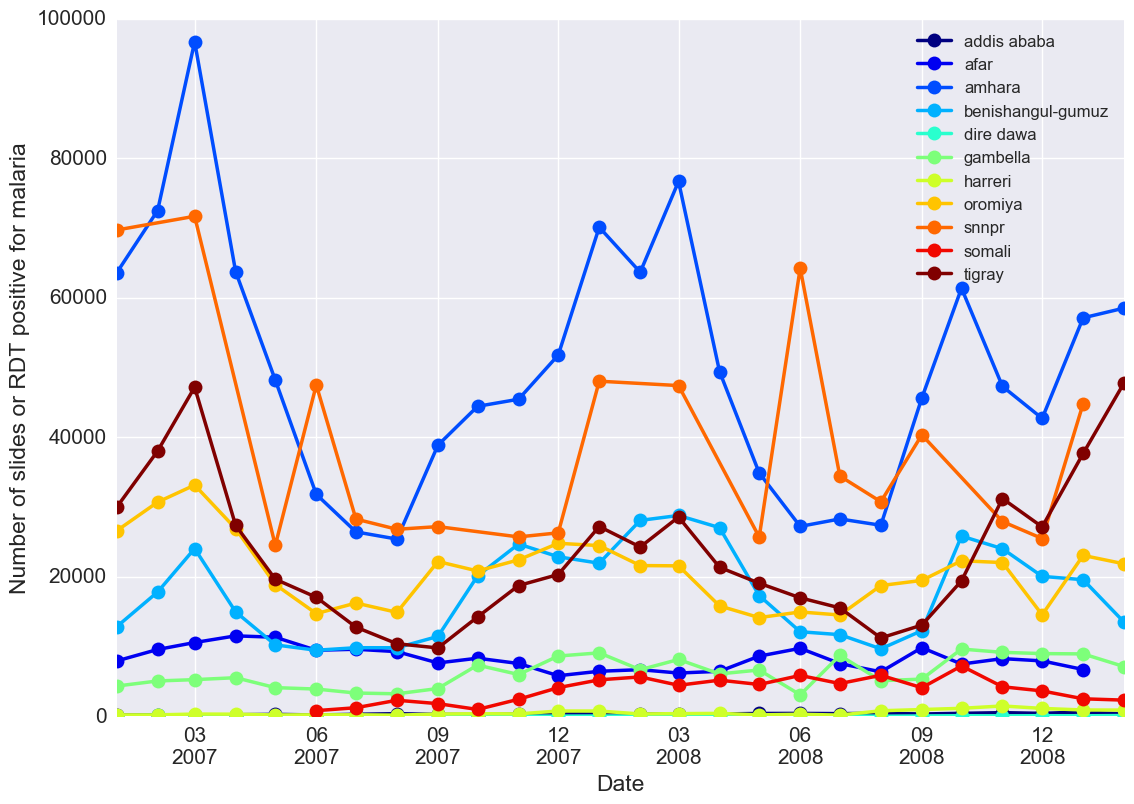

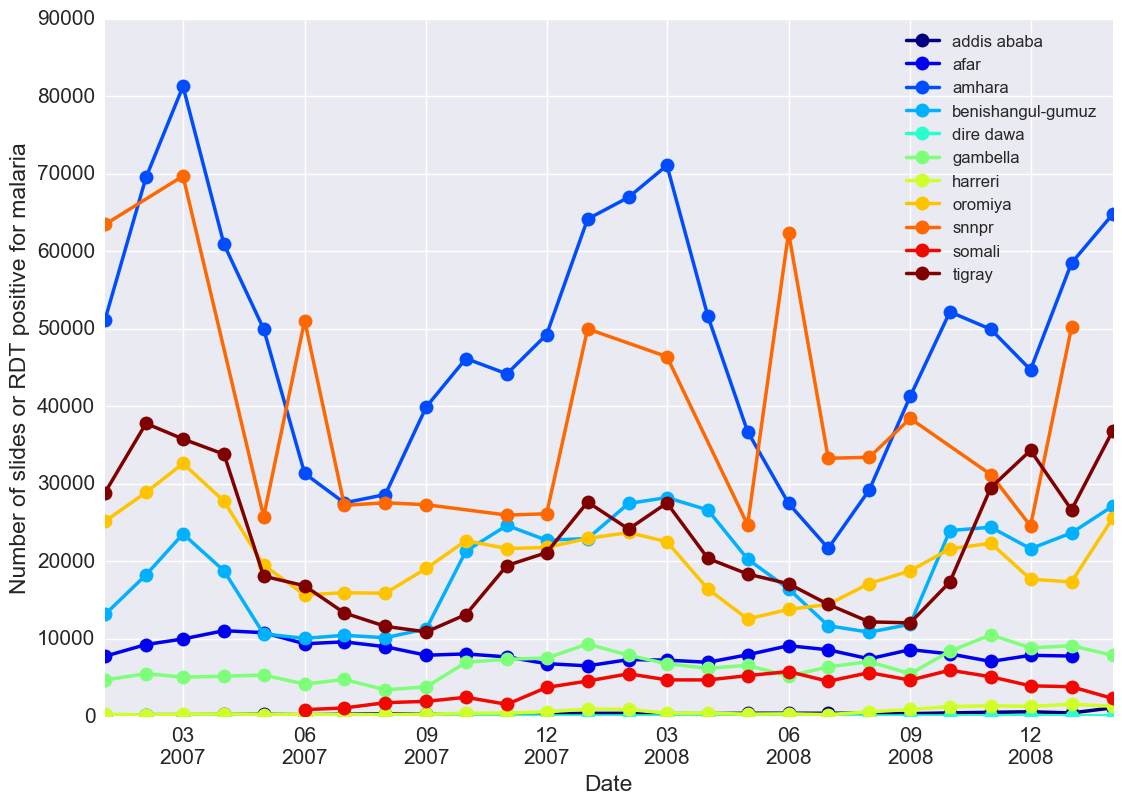

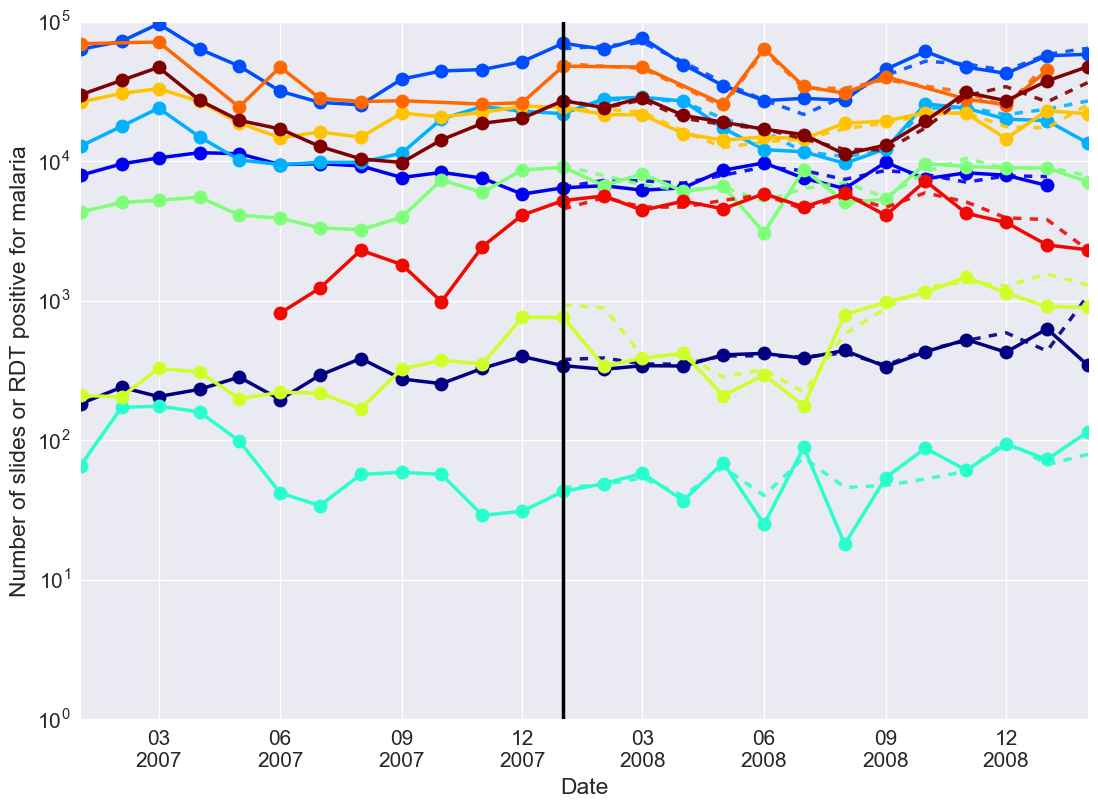

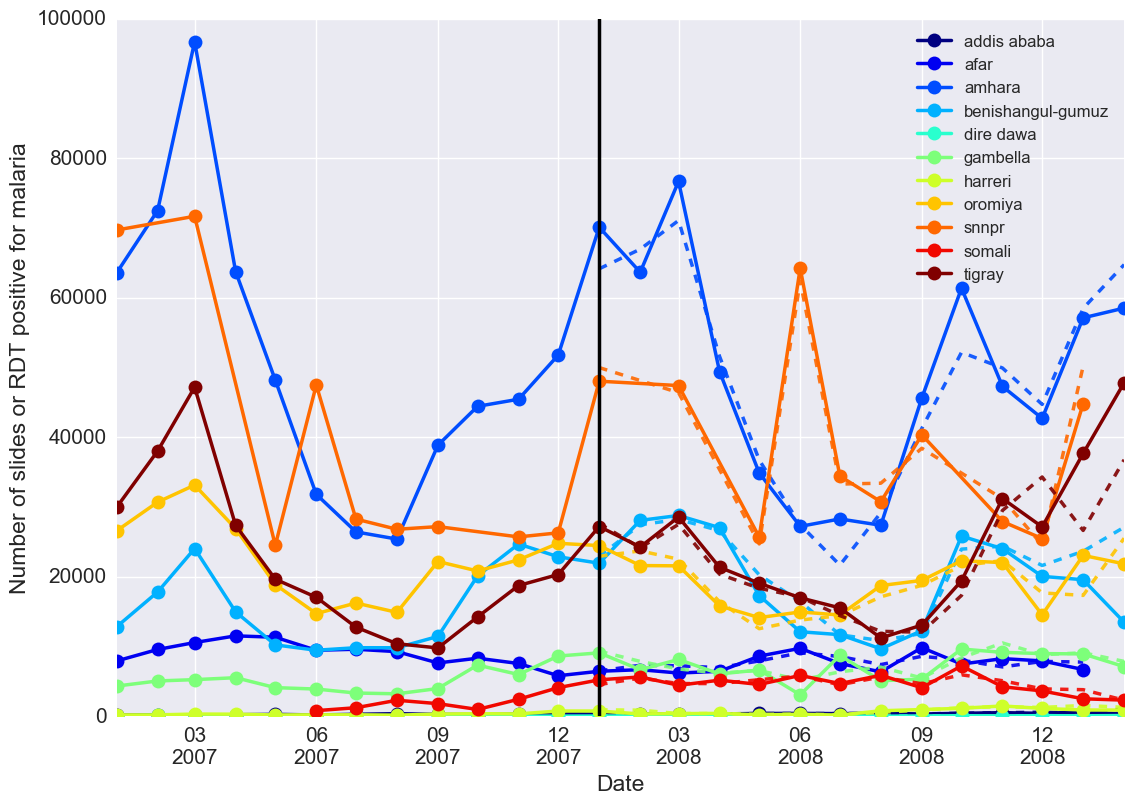

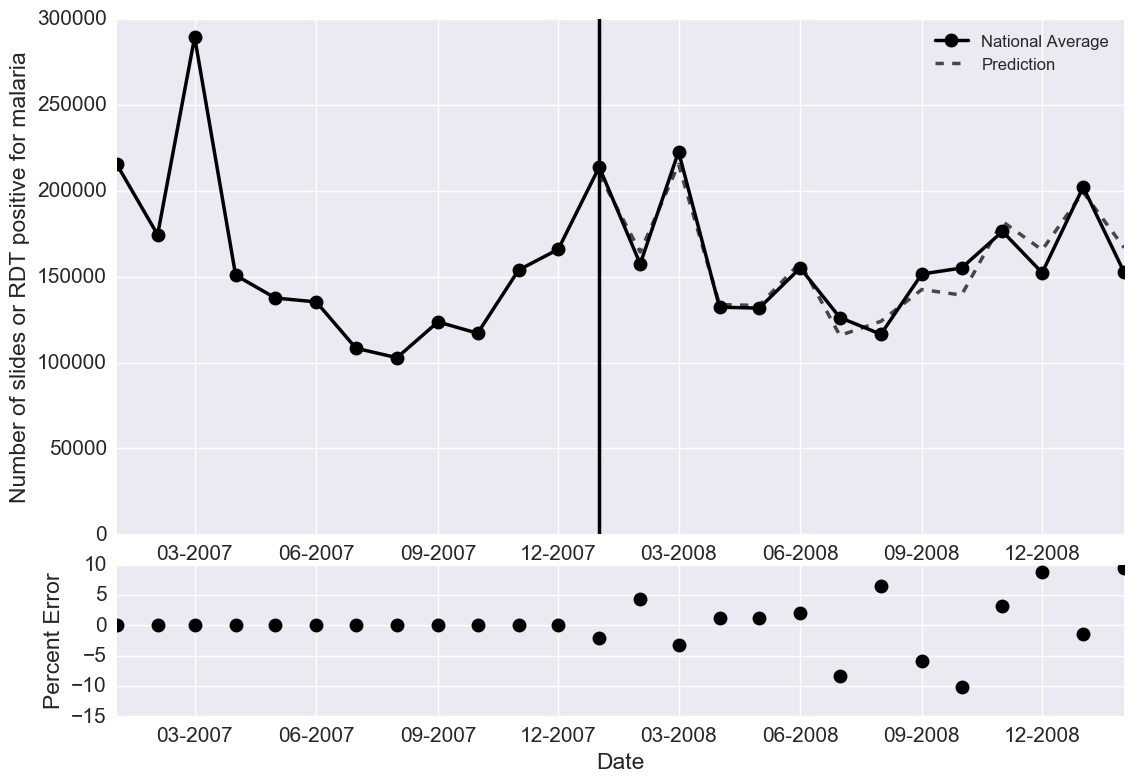

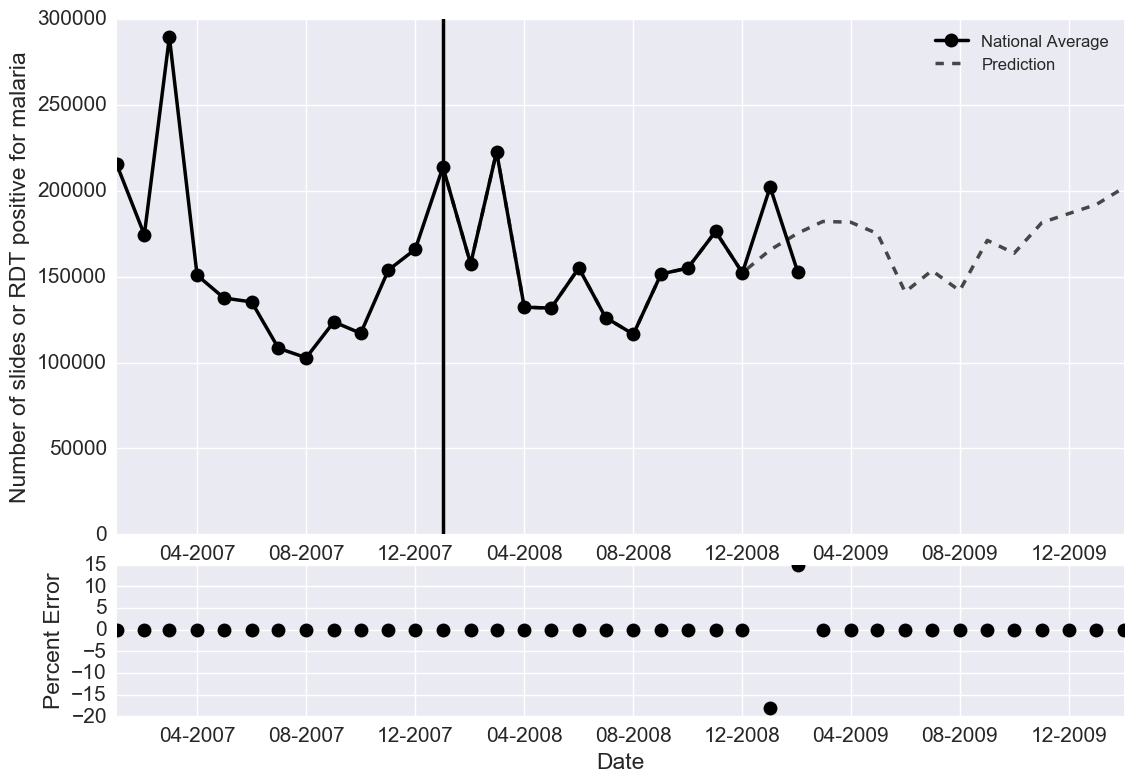

In [2347]:
indicator = 'Number of slides or RDT positive for malaria'
series_plot = plot_date_indicator(DF_shift, indicator, val_name='val')
series_d = plot_date_indicator(DF_shift, indicator, val_name='prediction')

RMSE_zone = plot_testing(DF_shift, indicator, val_name='val', pred_name = 'prediction', train_year = 2007, logscale = True, show_leg=False)
RMSE_zone = plot_testing(DF_shift, indicator, val_name='val', pred_name = 'prediction', train_year = 2007, logscale = False)
to_plot, predict_plot, RMSE_n = plot_testing_nation(DF_shift, indicator, val_name='val', pred_name = 'prediction', train_year = 2007)


# monthly forcasting
to_plot, predict_plot, RMSE_n_for = plot_forcast_nation(DF_shift, ext_DF, indicator, val_name='val', train_year = 2007)




In [2352]:
ind_names

['Number of slides or RDT positive for malaria',
 'Number of slides or RDT positive for malaria < 5 years: Females',
 'Number of slides or RDT positive for malaria < 5 years: Males',
 'Number of slides or RDT positive for malaria 5-14 years: Females',
 'Number of slides or RDT positive for malaria 5-14 years: Males',
 'Number of slides or RDT positive for malaria >=15 years: Females',
 'Number of slides or RDT positive for malaria >=15 years: Males']

In [2340]:
RMSE_n_for

0.23662920108566676

<h1> Results of 1 year of fitting and 1 year of testing </h1>

<h3> Average national RMSE </h3>

In [2337]:
RMSE_n

0.12133468648675583

<h3> Average RMSE by zone </h3>

In [2339]:
mean([val[1] for val in RMSE_zone])

0.35402736609050528

In [1952]:
RMSE_n = mean(sqrt((to_plot - predict_plot)**2) / to_plot)
((to_plot - predict_plot) / to_plot).replace(nan,0)

0.11917393153977016

In [1328]:
print sqrt(mean((DF_shift['val']-DF_shift['prediction'])**2))
sqrt(DF_shift.groupby('Region').mse.mean())/DF_shift.groupby('Region').mse.mean()*100

2181.89145318


Region
addis ababa          2.185701
afar                 0.145420
amhara               0.020415
benishangul-gumuz    0.048518
dire dawa            4.505378
gambella             0.120432
harreri              0.683319
oromiya              0.066588
snnpr                0.048772
somali               0.212595
tigray               0.030597
Name: mse, dtype: float64

<h1> Extrapolate 1 year </h1>

In [2271]:
DF_shift

Indicator_id     val    Region  \
Real_Date                                           
2014-09-11  hmis_indicator_3199    14.0   harreri   
2014-10-11  hmis_indicator_3199    14.0   harreri   
2014-11-10  hmis_indicator_3199    25.0   harreri   
2014-12-10  hmis_indicator_3199    22.0   harreri   
2015-01-09  hmis_indicator_3199    13.0   harreri   
2015-02-08  hmis_indicator_3199    18.0   harreri   
2015-03-10  hmis_indicator_3199     8.0   harreri   
2015-04-09  hmis_indicator_3199    23.0   harreri   
2015-05-09  hmis_indicator_3199    29.0   harreri   
2015-06-08  hmis_indicator_3199    31.0   harreri   
2015-07-08  hmis_indicator_3199    14.0   harreri   
2015-08-07  hmis_indicator_3199    75.0   harreri   
2015-09-12  hmis_indicator_3199    78.0   harreri   
2015-10-12  hmis_indicator_3199    23.0   harreri   
2015-11-11  hmis_indicator_3199    18.0   harreri   
2015-12-11  hmis_indicator_3199    26.0   harreri   
2016-01-10  hmis_indicator_3199    19.0   harreri   
2016-02-09  hmis_indicator_3199    15.0   harreri   
2016-03-10  hmis_indicator_3199     7.0   harreri   
2016-04-09  hmis_indicator_3199    46.0   harreri   
2016-05-09  hmis_indicator_3199    68.0   harreri   
2016-06-08  hmis_indicator_3199    89.0   harreri   
2016-07-08  hmis_indicator_3199   130.0   harreri   
2016-08-07  hmis_indicator_3199    67.0   harreri   
2016-09-11  hmis_indicator_3199    61.0   harreri   
...                         ...     ...       ...   
2014-10-11  hmis_indicator_4531  5072.0  gambella   
2014-11-10  hmis_indicator_4531  5261.0  gambella   
2014-12-10  hmis_indicator_4531  5538.0  gambella   
2015-01-09  hmis_indicator_4531  4116.0  gambella   
2015-02-08  hmis_indicator_4531  3911.0  gambella   
2015-03-10  hmis_indicator_4531  3341.0  gambella   
2015-04-09  hmis_indicator_4531  3230.0  gambella   
2015-05-09  hmis_indicator_4531  3987.0  gambella   
2015-06-08  hmis_indicator_4531  7349.0  gambella   
2015-07-08  hmis_indicator_4531  5994.0  gambella   
2015-08-07  hmis_indicator_4531  8644.0  gambella   
2015-09-12  hmis_indicator_4531  9102.0  gambella   
2015-10-12  hmis_indicator_4531  6682.0  gambella   
2015-11-11  hmis_indicator_4531  8152.0  gambella   
2015-12-11  hmis_indicator_4531  6082.0  gambella   
2016-01-10  hmis_indicator_4531  6644.0  gambella   
2016-02-09  hmis_indicator_4531  3081.0  gambella   
2016-03-10  hmis_indicator_4531  8736.0  gambella   
2016-04-09  hmis_indicator_4531  5106.0  gambella   
2016-05-09  hmis_indicator_4531  5338.0  gambella   
2016-06-08  hmis_indicator_4531  9646.0  gambella   
2016-07-08  hmis_indicator_4531  9173.0  gambella   
2016-08-07  hmis_indicator_4531  8995.0  gambella   
2016-09-11  hmis_indicator_4531  8950.0  gambella   
2016-10-11  hmis_indicator_4531  7129.0  gambella   

                                                    Indicator  gen_cat  \
Real_Date                                                                
2014-09-11  Number of slides or RDT positive for malaria <...        1   
2014-10-11  Number of slides or RDT positive for malaria <...        1   
2014-11-10  Number of slides or RDT positive for malaria <...        1   
2014-12-10  Number of slides or RDT positive for malaria <...        1   
2015-01-09  Number of slides or RDT positive for malaria <...        1   
2015-02-08  Number of slides or RDT positive for malaria <...        1   
2015-03-10  Number of slides or RDT positive for malaria <...        1   
2015-04-09  Number of slides or RDT positive for malaria <...        1   
2015-05-09  Number of slides or RDT positive for malaria <...        1   
2015-06-08  Number of slides or RDT positive for malaria <...        1   
2015-07-08  Number of slides or RDT positive for malaria <...        1   
2015-08-07  Number of slides or RDT positive for malaria <...        1   
2015-09-12  Number of slides or RDT positive for malaria <...        1   
2015-10-12  Number of slides or RDT positive for malaria <...        1   
2015-11-11  Number of sli

In [2372]:
# This is already cut on one indicator
DF_test = DF_shift.reset_index().set_index(['Region','E_Date'])

#forcast the training data
DF_test = DF_training.reset_index().set_index(['Region','E_Date'])

<h3> extrapolate one month at a time for each Region</h3>

In [2373]:
ext_DF = pd.DataFrame()

for region in series_d.index.levels[0]:
    
    DF_temp = DF_test.loc[region]

    for xx in range(13):
        last_entry = DF_temp.tail(1).reset_index()

        x = last_entry[features].values.reshape(1,-1)

        # predict new value:
        new_val = RF.predict(x)

        last_entry['val'] = new_val

        # increment date

        last_entry['E_Date'] = add_one_month(last_entry['E_Date'][0])
        last_entry.set_index('E_Date', inplace=True)

        # replace Real_Date with incremented E_Date
        last_entry['Real_Date'] = ethiopian_date.EthiopianDateConverter.date_to_gregorian(last_entry.index[0])

        last_entry.reset_index(inplace = True)

        last_entry['E_year'] = last_entry['E_Date'][0].year
        last_entry['E_month'] = last_entry['E_Date'][0].month
        last_entry['month'] = last_entry['Real_Date'][0].month
        last_entry['year'] = last_entry['Real_Date'][0].year

        #update current weather info

        last_entry['temp'] = [DF_weather.loc[capital,'temp'][inv_month_map[month]] for capital,month in zip(last_entry['capital'],last_entry['month'])]
        last_entry['prec_mm'] = [DF_weather.loc[capital,'prec_mm'][inv_month_map[month]] for capital,month in zip(last_entry['capital'],last_entry['month'])]
        last_entry['prec_mm'] = last_entry['prec_mm'].replace(nan,0)

        last_entry['temp_cat'] = [temp_map(temp) for temp in last_entry['temp']]
        last_entry['prec_cat'] = [prec_map(prec) for prec in last_entry['prec_mm']]

        # The hard part... add the extrapolations 

        last_entry['val_shift_1'] = DF_temp.iloc[-1]['val']
        last_entry['temp_shift_1'] = DF_temp.iloc[-1]['temp']
        last_entry['temp_cat_shift_1'] = DF_temp.iloc[-1]['temp_cat']
        last_entry['prec_shift_1'] = DF_temp.iloc[-1]['prec_mm']
        last_entry['prec_cat_shift_1'] = DF_temp.iloc[-1]['prec_cat']
        #DF_ext['Region_shift_1'] = DF_temp.iloc[-1]['Region']
        #DF_ext['Ind_shift_1'] = DF_temp.iloc[-1]['Indicator']
        last_entry['temp_delta'] = last_entry['temp'] - DF_temp.iloc[-1]['temp_shift_1']
        last_entry['prec_delta'] = last_entry['prec_mm'] - DF_temp.iloc[-1]['prec_shift_1']

        last_entry['val_shift_2'] = DF_temp.iloc[-2]['val']
        last_entry['temp_shift_2'] = DF_temp.iloc[-2]['temp']
        last_entry['temp_cat_shift_2'] = DF_temp.iloc[-2]['temp_cat']
        last_entry['prec_shift_2'] = DF_temp.iloc[-2]['prec_mm']
        last_entry['prec_cat_shift_2'] = DF_temp.iloc[-2]['prec_cat']
        #last_entry['Region_shift_2'] = DF_ext.shift(2)['Region']
        #last_entry['Ind_shift_2'] = DF_ext.shift(2)['Indicator']
        last_entry['val_delta'] =  (last_entry['val_shift_1'] - last_entry['val_shift_2']) / last_entry['val_shift_2']


        # tack on to the end of the DF
        last_entry.set_index('E_Date', inplace = True)
        DF_temp = DF_temp.append(last_entry)
        
    # add back the region name   
    DF_temp['Region'] = region
    ext_DF = pd.concat([ext_DF, DF_temp])

ext_DF.reset_index(inplace = True)   
ext_DF.set_index('Real_Date', inplace = True)

In [2329]:
RMSE_zone

[(u'addis ababa', 0.34884341651316036),
 (u'afar', 0.27042664757457119),
 (u'amhara', 0.35375260719082585),
 (u'benishangul-gumuz', 0.80609137210566273),
 (u'dire dawa', 0.50011943145776094),
 (u'gambella', 0.44683961779255021),
 (u'harreri', 2.0544196031353081),
 (u'oromiya', 0.40754390429270448),
 (u'snnpr', 0.44101248441796465),
 (u'somali', 0.45011710825906448),
 (u'tigray', 0.31342226250475824)]

UnboundLocalError: local variable 'RMSE_n' referenced before assignment

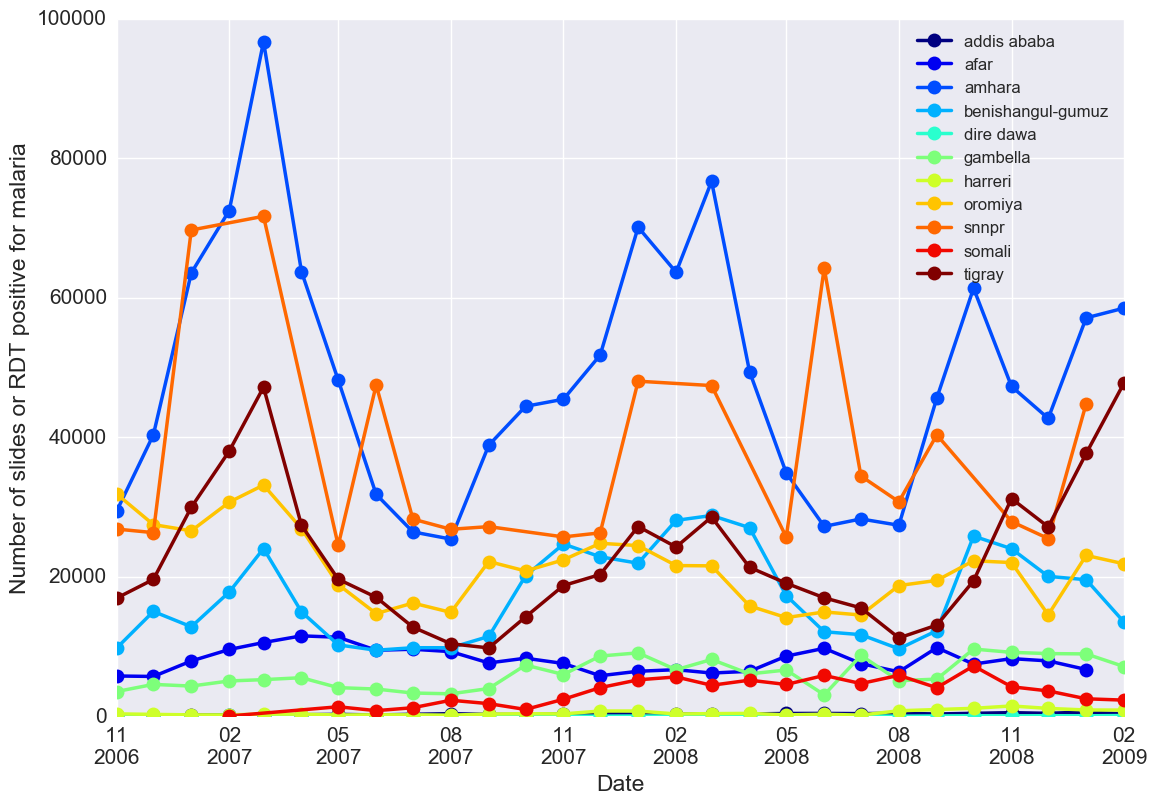

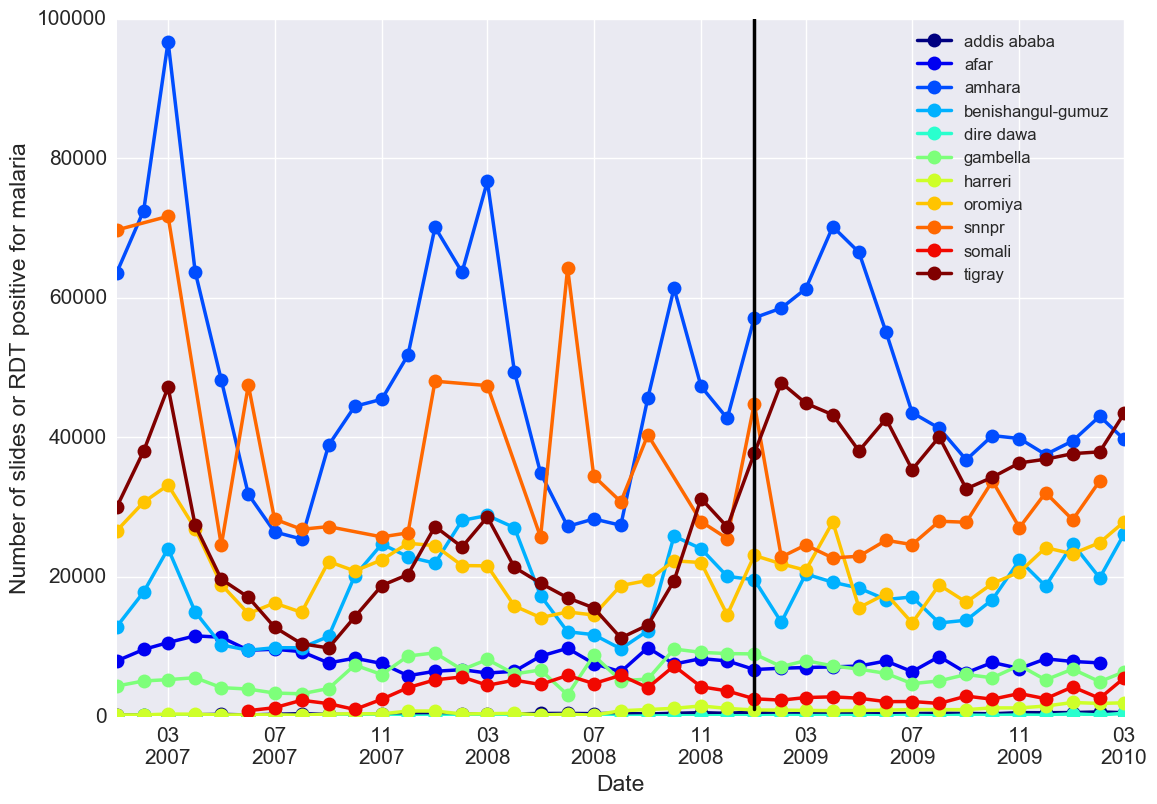

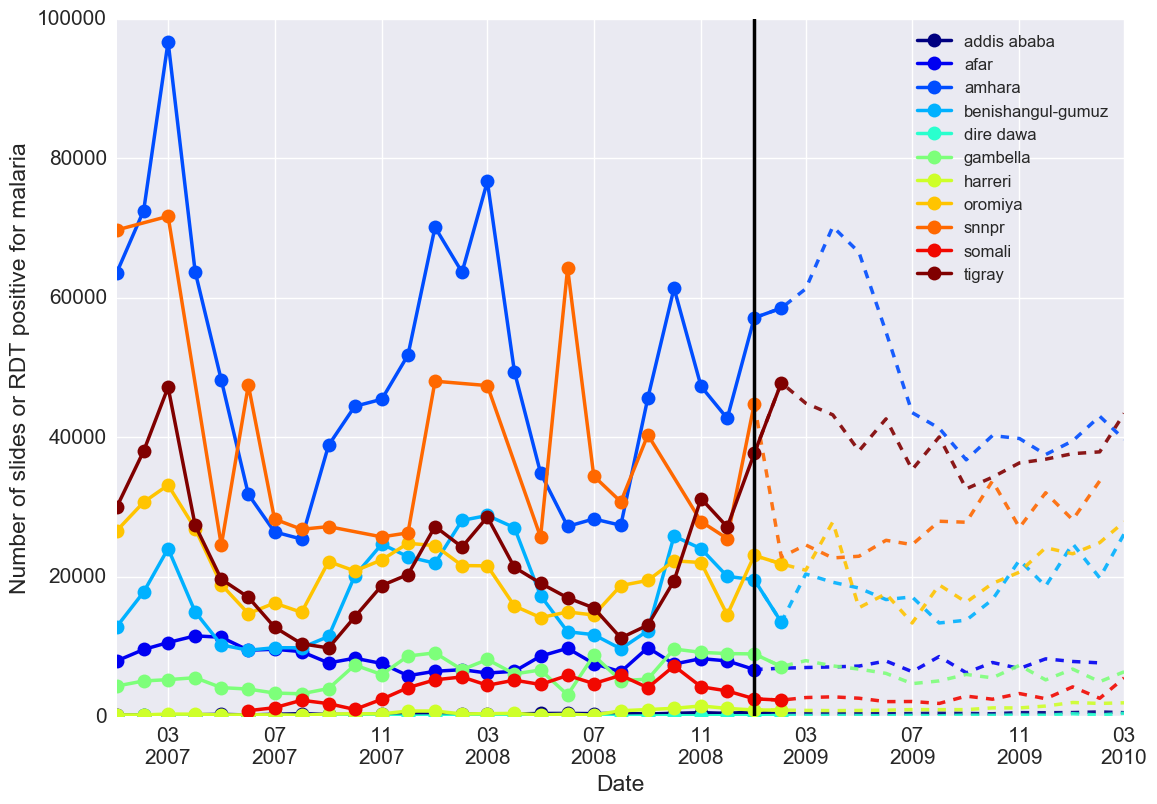

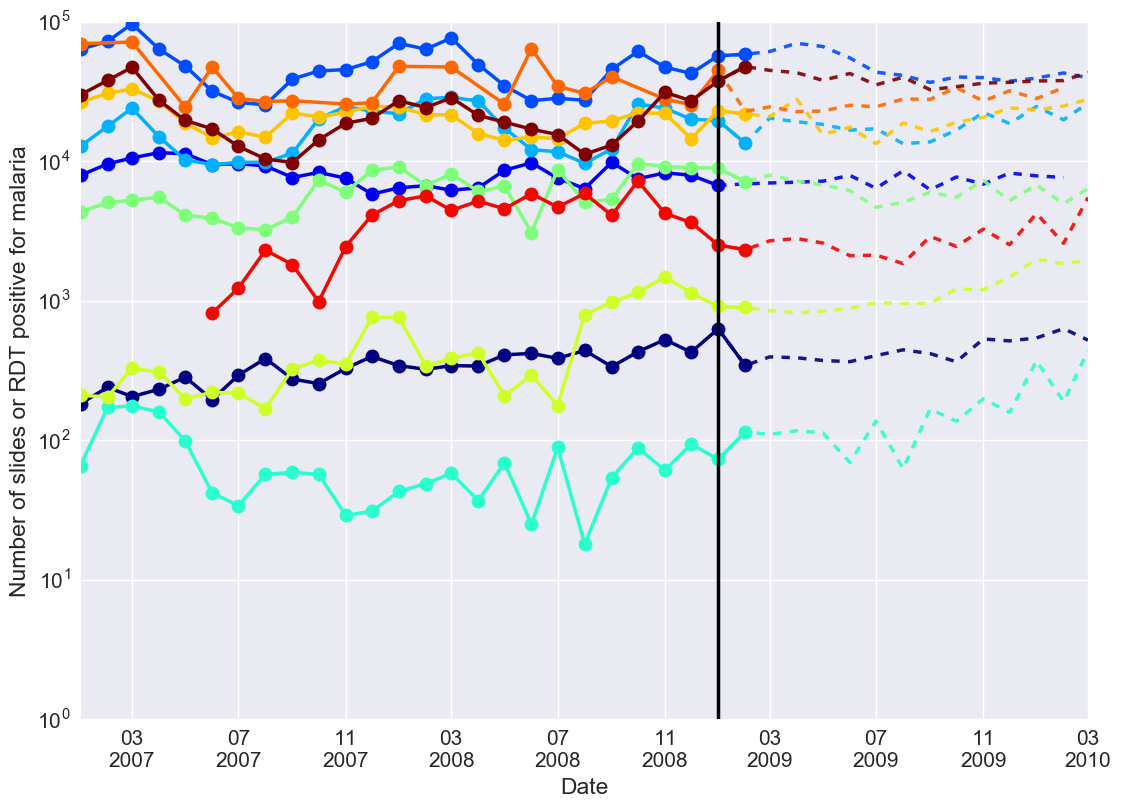

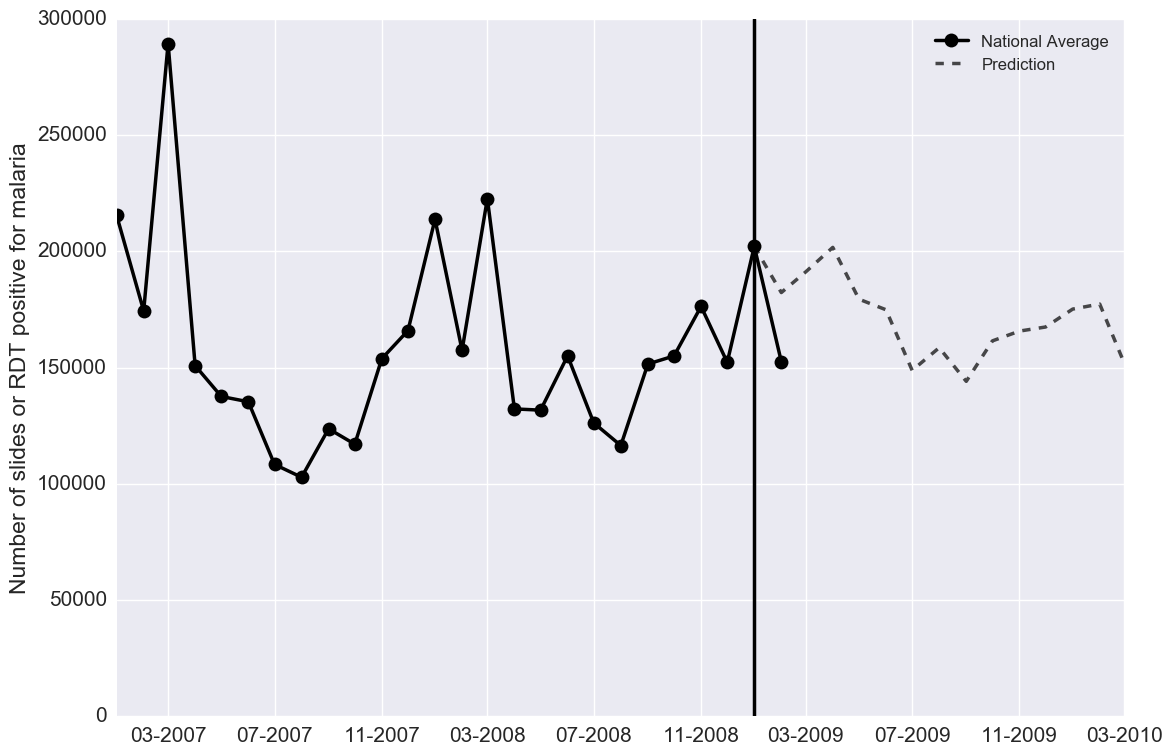

In [2374]:
series_plot = plot_date_indicator(DF_ind, indicator, val_name='val')
series_plot = plot_date_indicator(ext_DF, indicator, val_name='val')
#plt.plot_date(['2009-03-01', '2009-03-01'],[1000,100000],'-', color = 'k')
plt.plot_date(['2009-01-01', '2009-01-01'],[1000,100000],'-', color = 'k')

RMSE_zone = plot_forcasting(DF_shift, ext_DF, indicator, val_name='val', train_year = 2008, logscale = False, show_leg=True)


RMSE_zone = plot_forcasting(DF_shift, ext_DF, indicator, val_name='val', train_year = 2008, logscale = True, show_leg=False)

to_plot, predict_plot, RMSE_n_for = plot_forcast_nation(DF_shift, ext_DF, indicator, val_name='val', train_year = 2008, res=False)



In [2334]:
mean([val[1] for val in RMSE_zone])

0.58114440502221199

In [1554]:
DF_ind

Indicator_id          val    Region  \
Real_Date                                                
2015-09-12     hmis_c_1_4_2_5_4     0.991171   harreri   
2014-07-08  hmis_indicator_3199    21.000000   harreri   
2014-08-07  hmis_indicator_3199    35.000000   harreri   
2014-09-11  hmis_indicator_3199    14.000000   harreri   
2014-10-11  hmis_indicator_3199    14.000000   harreri   
2014-11-10  hmis_indicator_3199    25.000000   harreri   
2014-12-10  hmis_indicator_3199    22.000000   harreri   
2015-01-09  hmis_indicator_3199    13.000000   harreri   
2015-02-08  hmis_indicator_3199    18.000000   harreri   
2015-03-10  hmis_indicator_3199     8.000000   harreri   
2015-04-09  hmis_indicator_3199    23.000000   harreri   
2015-05-09  hmis_indicator_3199    29.000000   harreri   
2015-06-08  hmis_indicator_3199    31.000000   harreri   
2015-07-08  hmis_indicator_3199    14.000000   harreri   
2015-08-07  hmis_indicator_3199    75.000000   harreri   
2015-09-12  hmis_indicator_3199    78.000000   harreri   
2015-10-12  hmis_indicator_3199    23.000000   harreri   
2015-11-11  hmis_indicator_3199    18.000000   harreri   
2015-12-11  hmis_indicator_3199    26.000000   harreri   
2016-01-10  hmis_indicator_3199    19.000000   harreri   
2016-02-09  hmis_indicator_3199    15.000000   harreri   
2016-03-10  hmis_indicator_3199     7.000000   harreri   
2016-04-09  hmis_indicator_3199    46.000000   harreri   
2016-05-09  hmis_indicator_3199    68.000000   harreri   
2016-06-08  hmis_indicator_3199    89.000000   harreri   
...                         ...          ...       ...   
2014-10-11  hmis_indicator_4531  5072.000000  gambella   
2014-11-10  hmis_indicator_4531  5261.000000  gambella   
2014-12-10  hmis_indicator_4531  5538.000000  gambella   
2015-01-09  hmis_indicator_4531  4116.000000  gambella   
2015-02-08  hmis_indicator_4531  3911.000000  gambella   
2015-03-10  hmis_indicator_4531  3341.000000  gambella   
2015-04-09  hmis_indicator_4531  3230.000000  gambella   
2015-05-09  hmis_indicator_4531  3987.000000  gambella   
2015-06-08  hmis_indicator_4531  7349.000000  gambella   
2015-07-08  hmis_indicator_4531  5994.000000  gambella   
2015-08-07  hmis_indicator_4531  8644.000000  gambella   
2015-09-12  hmis_indicator_4531  9102.000000  gambella   
2015-10-12  hmis_indicator_4531  6682.000000  gambella   
2015-11-11  hmis_indicator_4531  8152.000000  gambella   
2015-12-11  hmis_indicator_4531  6082.000000  gambella   
2016-01-10  hmis_indicator_4531  6644.000000  gambella   
2016-02-09  hmis_indicator_4531  3081.000000  gambella   
2016-03-10  hmis_indicator_4531  8736.000000  gambella   
2016-04-09  hmis_indicator_4531  5106.000000  gambella   
2016-05-09  hmis_indicator_4531  5338.000000  gambella   
2016-06-08  hmis_indicator_4531  9646.000000  gambella   
2016-07-08  hmis_indicator_4531  9173.000000  gambella   
2016-08-07  hmis_indicator_4531  8995.000000  gambella   
2016-09-11  hmis_indicator_4531  8950.000000  gambella   
2016-10-11  hmis_indicator_4531  7129.000000  gambella   

                                                    Indicator     E_Date  \
Real_Date                                                                  
2015-09-12  Proportion of targeted HH covered with LLIN in... 2008-01-01   
2014-07-08  Number of slides or RDT positive for malaria <... 2006-11-01   
2014-08-07  Number of slides or RDT positive for malaria <... 2006-12-01   
2014-09-11  Number of slides or RDT positive for malaria <... 2007-01-01   
2014-10-11  Number of slides or RDT positive for malaria <... 2007-02-01   
2014-11-10  Number of slides or RDT positive for malaria <... 2007-03-01   
2014-12-10  Number of slides or RDT positive for malaria <... 2007-04-01   
2015-01-09  Number of slides or RDT positive for malaria <... 2007-05-01   
2015-02-08  Number of slides or RDT positive for malaria <... 2007-06-01   
2015-03-10  Number of slides or RDT positive for malaria <... 2007-07-01   
2015-04-09  Number of slides or 

<h1> Write to json or cvs </h1>

In [2375]:
ext_DF

E_Date         Indicator_id      val  \
Real_Date                                                      
2014-09-11 00:00:00 2007-01-01  hmis_indicator_3199      6.0   
2014-10-11 00:00:00 2007-02-01  hmis_indicator_3199     42.0   
2014-11-10 00:00:00 2007-03-01  hmis_indicator_3199      7.0   
2014-12-10 00:00:00 2007-04-01  hmis_indicator_3199      8.0   
2015-01-09 00:00:00 2007-05-01  hmis_indicator_3199      7.0   
2015-02-08 00:00:00 2007-06-01  hmis_indicator_3199      8.0   
2015-03-10 00:00:00 2007-07-01  hmis_indicator_3199      4.0   
2015-04-09 00:00:00 2007-08-01  hmis_indicator_3199     20.0   
2015-05-09 00:00:00 2007-09-01  hmis_indicator_3199     13.0   
2015-06-08 00:00:00 2007-10-01  hmis_indicator_3199     14.0   
2015-07-08 00:00:00 2007-11-01  hmis_indicator_3199     20.0   
2015-08-07 00:00:00 2007-12-01  hmis_indicator_3199      6.0   
2015-09-12 00:00:00 2008-01-01  hmis_indicator_3199      4.0   
2015-10-12 00:00:00 2008-02-01  hmis_indicator_3199      3.0   
2015-11-11 00:00:00 2008-03-01  hmis_indicator_3199      4.0   
2015-12-11 00:00:00 2008-04-01  hmis_indicator_3199      9.0   
2016-01-10 00:00:00 2008-05-01  hmis_indicator_3199     11.0   
2016-02-09 00:00:00 2008-06-01  hmis_indicator_3199      7.0   
2016-03-10 00:00:00 2008-07-01  hmis_indicator_3199      8.0   
2016-04-09 00:00:00 2008-08-01  hmis_indicator_3199     11.0   
2016-05-09 00:00:00 2008-09-01  hmis_indicator_3199     22.0   
2016-06-08 00:00:00 2008-10-01  hmis_indicator_3199     18.0   
2016-07-08 00:00:00 2008-11-01  hmis_indicator_3199     12.0   
2016-08-07 00:00:00 2008-12-01  hmis_indicator_3199      9.0   
2016-09-11 00:00:00 2009-01-01  hmis_indicator_3199     11.0   
...                        ...                  ...      ...   
2015-11-11 00:00:00 2008-03-01  hmis_indicator_4531  28575.0   
2015-12-11 00:00:00 2008-04-01  hmis_indicator_4531  21364.0   
2016-01-10 00:00:00 2008-05-01  hmis_indicator_4531  19084.0   
2016-02-09 00:00:00 2008-06-01  hmis_indicator_4531  16994.0   
2016-03-10 00:00:00 2008-07-01  hmis_indicator_4531  15545.0   
2016-04-09 00:00:00 2008-08-01  hmis_indicator_4531  11239.0   
2016-05-09 00:00:00 2008-09-01  hmis_indicator_4531  13080.0   
2016-06-08 00:00:00 2008-10-01  hmis_indicator_4531  19425.0   
2016-07-08 00:00:00 2008-11-01  hmis_indicator_4531  31221.0   
2016-08-07 00:00:00 2008-12-01  hmis_indicator_4531  27160.0   
2016-09-11 00:00:00 2009-01-01  hmis_indicator_4531  37686.0   
2016-10-11 00:00:00 2009-02-01  hmis_indicator_4531  47822.0   
2016-11-10          2009-03-01  hmis_indicator_4531  44889.0   
2016-12-10          2009-04-01  hmis_indicator_4531  43227.8   
2017-01-09          2009-05-01  hmis_indicator_4531  38051.7   
2017-02-08          2009-06-01  hmis_indicator_4531  42648.8   
2017-03-10          2009-07-01  hmis_indicator_4531  35371.4   
2017-04-09          2009-08-01  hmis_indicator_4531  40057.7   
2017-05-09          2009-09-01  hmis_indicator_4531  32620.5   
2017-06-08          2009-10-01  hmis_indicator_4531  34279.5   
2017-07-08          2009-11-01  hmis_indicator_4531  36333.4   
2017-08-07          2009-12-01  hmis_indicator_4531  36864.5   
2017-09-11          2010-01-01  hmis_indicator_4531  37661.6   
2017-10-11          2010-02-01  hmis_indicator_4531  37918.4   
2017-11-10          2010-03-01  hmis_indicator_4531  43423.2   

                                                             Indicator  \
Real_Date                                                                
2014-09-11 00:00:00  Number of slides or RDT positive for malaria <...   
2014-10-11 00:00:00  Number of slides or RDT positive for malaria <...   
2014-11-10 00:00:00  Number of slides or RDT positive for malaria <...   
2014-12-10 00:00:00  Number of slides or RDT positive for malaria <...   
2015-01-09 00:00:00  Number of slides or RDT positive for malaria <...   
2015-02-08 00:00:00  Number of slides or RDT positive for malaria <...   
2015-03-10 00:00:00  Number of slides o

<h1> Canonical region information mapping </h1>

In [2582]:
DF_region_map = pd.read_csv('/Users/attiladobi/zenysis/pipeline/auto/ethiopia/bin/shared/data/region_mapped.csv', \
                           float_precision='high', dtype={'RegionLat': np.float128, 'RegionLon': np.float128})
DF_region_map['RegionName_lower'] = [name.lower() for name in DF_region_map['RegionName']]
DF_region_map.set_index('RegionName_lower', inplace=True)
                                     

In [2604]:
pd.options.display.float_format = '{:20,.5f}'.format
DF_region_map['RegionLat'].astype(np.float128)

RegionName_lower
addis ababa                      8.98048
afar                            12.03645
amhara                          11.56495
benishangul-gumuz               10.50292
dire dawa                        9.60627
gambella                         7.68385
harreri                          9.28966
oromiya                          7.32357
somali                           6.93278
snnpr                            6.46581
tigray                          13.77711
Name: RegionLat, dtype: float128

In [2588]:
lat_lon_map = { 'Addis Ababa': (8.980483001254077, 38.78553834507309), 
'Afar': (12.036445063176075, 40.772735414805204),
'Amhara': (11.5649524790046, 38.04353615460529),
'Benishangul-Gumuz': (10.502924415157686, 35.44030701966273),
'Dire Dawa': (9.606269193503696, 42.003026894902156),
'Gambella':(7.683850454124325, 34.33675414861345),
'Harreri': (9.289660023774802, 42.172525872858124),
'Oromiya': (7.323567398452454, 38.66052453790127),
'Somali': (6.932778405509416, 43.32988331430246),
'SNNPR': (6.465808724769859, 36.806469462905675),
'Tigray': (13.777114742142253, 38.43867332133363 ),  
}    
    

In [2636]:
DF2['byGeo'][0]

{u'addis ababa______': {u'data': {u'all': {u'2000-01-01T00:00:00.000Z': {u'hmis_c_1_4_2_5_4': 0,
     u'hmis_indicator_3199': 305,
     u'hmis_indicator_3200': 130,
     u'hmis_indicator_3201': 435,
     u'hmis_indicator_3202': 322,
     u'hmis_indicator_3203': 5570,
     u'hmis_indicator_3204': 2486,
     u'hmis_indicator_3205': 50024,
     u'hmis_indicator_4531': 9248}},
   u'month': {u'2014-07-08T00:00:00.000Z': {u'Real_Date': u'2014-07-08T00:00:00.000Z',
     u'hmis_c_1_4_2_5_4': 0,
     u'hmis_indicator_3199': 5,
     u'hmis_indicator_3200': 1,
     u'hmis_indicator_3201': 18,
     u'hmis_indicator_3202': 6,
     u'hmis_indicator_3203': 72,
     u'hmis_indicator_3204': 30,
     u'hmis_indicator_3205': 427,
     u'hmis_indicator_4531': 132},
    u'2014-08-07T00:00:00.000Z': {u'Real_Date': u'2014-08-07T00:00:00.000Z',
     u'hmis_c_1_4_2_5_4': 0,
     u'hmis_indicator_3199': 4,
     u'hmis_indicator_3200': 0,
     u'hmis_indicator_3201': 4,
     u'hmis_indicator_3202': 9,
     u'hmi

In [2633]:
lat_lon_map['SNNPR']

(6.465808724769859, 36.806469462905675)

<h1> format the data into json for injestion </h1>

In [2602]:
Formatted_DF = ext_DF[['val', 'Region', 'Indicator_id']].rename(columns = \
                                {'Indicator_id': 'field', 'Region': 'RegionName'})
Formatted_DF['field'] = ['forecast_%s' % (field) for field in Formatted_DF['field']]
Formatted_DF.index = pd.DatetimeIndex(Formatted_DF.index)

Formatted_DF['RegionLat'] = [DF_region_map.loc[region]['RegionLat'] for region in Formatted_DF['RegionName']]
Formatted_DF['RegionLon'] = [DF_region_map.loc[region]['RegionLon'] for region in Formatted_DF['RegionName']]
#finally overwrite the lowercased region name with the canonical value
Formatted_DF['RegionName'] = [DF_region_map.loc[region]['RegionName'] for region in Formatted_DF['RegionName']]

Formatted_DF['source'] ='forecast'
Formatted_DF['Real_Date'] = [date.strftime('%Y-%m-%d') for date in Formatted_DF.index]

Formatted_DF['RegionLat'] = [lat_lon_map[region][0] for region in Formatted_DF['RegionName']]
Formatted_DF['RegionLon'] = [lat_lon_map[region][1] for region in Formatted_DF['RegionName']]

In [2594]:
#Formatted_DF['val'] = Formatted_DF['val'].map(lambda x: float(x))

Formatted_DF.to_csv('Malaria_Forecast_2009.csv')
Formatted_DF.to_json('Malaria_Forecast_2009.json', orient='records', double_precision=15)


In [2632]:
#write to json
with open("forecast.json", "w") as outfile:
    for line in Formatted_DF.iterrows():
        line = line[1]
        region = line['RegionName']
        json.dump({'Real_Date':line['Real_Date'], 'RegionName': region, \
                   'val':line['val'], 'field':line['field'], \
                   'source':'forecast', 'RegionLat': lat_lon_map[region][0], \
                   'RegionLon': lat_lon_map[region][1]}, outfile, indent=4)

In [2627]:
for line in Formatted_DF.iterrows():
    print line[1]['RegionName']

Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addis Ababa
Addi

In [2624]:
line[0]

6.0

In [2]:
import pandas as pd

In [48]:
pd.read_csv('Malaria_Forecast_2009.csv').groupby('field').count()

Real_Date  val  RegionName  RegionLat  \
field                                                                 
forecast_hmis_indicator_3199        275  275         275        275   
forecast_hmis_indicator_3200        274  274         274        274   
forecast_hmis_indicator_3201        279  279         279        279   
forecast_hmis_indicator_3202        279  279         279        279   
forecast_hmis_indicator_3203        281  281         281        281   
forecast_hmis_indicator_3204        281  281         281        281   
forecast_hmis_indicator_4531        423  423         423        423   

                              RegionLon  source  Real_Date.1  
field                                                         
forecast_hmis_indicator_3199        275     275          275  
forecast_hmis_indicator_3200        274     274          274  
forecast_hmis_indicator_3201        279     279          279  
forecast_hmis_indicator_3202        279     279          279  
forecast_hmis_indicator_3203        281     281          281  
forecast_hmis_indicator_3204        281     281          281  
forecast_hmis_indicator_4531        423     423          423

In [25]:
data_json_str = "[" + ''.join(data) + "]"

In [27]:
data_json_str
#pd.read_json(data_json_str)

'[{    "RegionLon": 38.78553834507309,    "val": 6.0,    "field": "forecast_hmis_indicator_3199",    "Real_Date": "2014-09-11",    "source": "forecast",    "RegionLat": 8.980483001254077,    "RegionName": "Addis Ababa"}{    "RegionLon": 38.78553834507309,    "val": 42.0,    "field": "forecast_hmis_indicator_3199",    "Real_Date": "2014-10-11",    "source": "forecast",    "RegionLat": 8.980483001254077,    "RegionName": "Addis Ababa"}{    "RegionLon": 38.78553834507309,    "val": 7.0,    "field": "forecast_hmis_indicator_3199",    "Real_Date": "2014-11-10",    "source": "forecast",    "RegionLat": 8.980483001254077,    "RegionName": "Addis Ababa"}{    "RegionLon": 38.78553834507309,    "val": 8.0,    "field": "forecast_hmis_indicator_3199",    "Real_Date": "2014-12-10",    "source": "forecast",    "RegionLat": 8.980483001254077,    "RegionName": "Addis Ababa"}{    "RegionLon": 38.78553834507309,    "val": 7.0,    "field": "forecast_hmis_indicator_3199",    "Real_Date": "2015-01-09",    

In [13]:
with open('forecast.json', 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
DF = pd.read_json(data_json_str)

ValueError: Expected object or value

In [12]:
DF

{
    "RegionLon": 38.78553834507309              
    "val": 6.0                                  
    "field": "forecast_hmis_indicator_3199"     
    "Real_Date": "2014-09-11"                   
    "source": "forecast"                        
    "RegionLat": 8.980483001254077              
    "RegionName": "Addis Ababa"              NaN
}{                                           NaN
    "RegionLon": 38.78553834507309              
    "val": 42.0                                 
    "field": "forecast_hmis_indicator_3199"     
    "Real_Date": "2014-10-11"                   
    "source": "forecast"                        
    "RegionLat": 8.980483001254077              
    "RegionName": "Addis Ababa"              NaN
}{                                           NaN
    "RegionLon": 38.78553834507309              
    "val": 7.0                                  
    "field": "forecast_hmis_indicator_3199"     
    "Real_Date": "2014-11-10"                   
    "source": "forecast"                        
    "RegionLat": 8.980483001254077              
    "RegionName": "Addis Ababa"              NaN
}{                                           NaN
    "RegionLon": 38.78553834507309              
    "val": 8.0                                  
    "field": "forecast_hmis_indicator_3199"     
    "Real_Date": "2014-12-10"                   
    "source": "forecast"                        
    "RegionLat": 8.980483001254077              
...                                          ...
    "field": "forecast_hmis_indicator_4531"     
    "Real_Date": "2017-08-07"                   
    "source": "forecast"                        
    "RegionLat": 13.777114742142253             
    "RegionName": "Tigray"                   NaN
}{                                           NaN
    "RegionLon": 38.43867332133363              
    "val": 37661.6                              
    "field": "forecast_hmis_indicator_4531"     
    "Real_Date": "2017-09-11"                   
    "source": "forecast"                        
    "RegionLat": 13.777114742142253             
    "RegionName": "Tigray"                   NaN
}{                                           NaN
    "RegionLon": 38.43867332133363              
    "val": 37918.4                              
    "field": "forecast_hmis_indicator_4531"     
    "Real_Date": "2017-10-11"                   
    "source": "forecast"                        
    "RegionLat": 13.777114742142253             
    "RegionName": "Tigray"                   NaN
}{                                           NaN
    "RegionLon": 38.43867332133363              
    "val": 43423.2                              
    "field": "forecast_hmis_indicator_4531"     
    "Real_Date": "2017-11-10"                   
    "source": "forecast"                        
    "RegionLat": 13.777114742142253             
    "RegionName": "Tigray"                   NaN
}                                            NaN

[16736 rows x 1 columns]

<h1> update values for new month and new prediction </h1>

In [1432]:
DF_temp = DF_temp.append(last_entry)

In [1461]:
add_one_month(DF_temp.tail(1).index[0])

datetime.datetime(2009, 3, 1, 0, 0)

In [1528]:
#DF_temp.tail(1).index = add_one_month(DF_temp.tail(1).index[0])

In [ ]:
DF_temp.tail(1)

In [1343]:
series_d.index.levels[0]

Index([u'addis ababa', u'afar', u'amhara', u'benishangul-gumuz', u'dire dawa',
       u'gambella', u'harreri', u'oromiya', u'snnpr', u'somali', u'tigray'],
      dtype='object', name=u'Region')

<h1> Extrapolate for 1 year </h1>

In [1347]:
ext_range = pd.date_range('1/1/2009', periods=12, freq='M')
ext_dates = [set_to_first_of_month(date) for date in ext_range]

In [1378]:
DF_ext = pd.DataFrame(ext_dates, columns = ['E_Date'])

In [1379]:
DF_ext['Real_Date'] = [ethiopian_date.EthiopianDateConverter.date_to_gregorian(date) for date in DF_ext['E_Date']]
#DF_ext['Real_Date'] = [pd.datetime(date) for date in DF_ext['Real_Date']]

In [1380]:
region = series_d.index.levels[0][0]
DF_ext['Region'] = region

In [1381]:
DF_ext

E_Date   Real_Date       Region
0   2009-01-01  2016-09-11  addis ababa
1   2009-02-01  2016-10-11  addis ababa
2   2009-03-01  2016-11-10  addis ababa
3   2009-04-01  2016-12-10  addis ababa
4   2009-05-01  2017-01-09  addis ababa
5   2009-06-01  2017-02-08  addis ababa
6   2009-07-01  2017-03-10  addis ababa
7   2009-08-01  2017-04-09  addis ababa
8   2009-09-01  2017-05-09  addis ababa
9   2009-10-01  2017-06-08  addis ababa
10  2009-11-01  2017-07-08  addis ababa
11  2009-12-01  2017-08-07  addis ababa

In [1382]:
DF_ext['E_Date']

0     2009-01-01
1     2009-02-01
2     2009-03-01
3     2009-04-01
4     2009-05-01
5     2009-06-01
6     2009-07-01
7     2009-08-01
8     2009-09-01
9     2009-10-01
10    2009-11-01
11    2009-12-01
Name: E_Date, dtype: object

In [1383]:
#DF_ext['E_Date'] = DF_ext['E_Date'].astype(datetime64)
DF_ext.set_index('Real_Date', inplace=True)
DF_ext.index = DF_ext.index.astype(datetime64)
DF_ext['E_year'] = [val.year for val in DF_ext['E_Date']]
DF_ext['E_month'] = [val.month for val in DF_ext['E_Date']]
DF_ext['month'] = DF_ext.index.month
DF_ext['year'] = DF_ext.index.year

<h3> set indicator name </h3>

In [1385]:
DF_ext['Indicator'] = indicator

In [1386]:
DF_ext

E_Date       Region  E_year  E_month  month  year  \
Real_Date                                                           
2016-09-11  2009-01-01  addis ababa    2009        1      9  2016   
2016-10-11  2009-02-01  addis ababa    2009        2     10  2016   
2016-11-10  2009-03-01  addis ababa    2009        3     11  2016   
2016-12-10  2009-04-01  addis ababa    2009        4     12  2016   
2017-01-09  2009-05-01  addis ababa    2009        5      1  2017   
2017-02-08  2009-06-01  addis ababa    2009        6      2  2017   
2017-03-10  2009-07-01  addis ababa    2009        7      3  2017   
2017-04-09  2009-08-01  addis ababa    2009        8      4  2017   
2017-05-09  2009-09-01  addis ababa    2009        9      5  2017   
2017-06-08  2009-10-01  addis ababa    2009       10      6  2017   
2017-07-08  2009-11-01  addis ababa    2009       11      7  2017   
2017-08-07  2009-12-01  addis ababa    2009       12      8  2017   

                                               Indicator  
Real_Date                                                 
2016-09-11  Number of slides or RDT positive for malaria  
2016-10-11  Number of slides or RDT positive for malaria  
2016-11-10  Number of slides or RDT positive for malaria  
2016-12-10  Number of slides or RDT positive for malaria  
2017-01-09  Number of slides or RDT positive for malaria  
2017-02-08  Number of slides or RDT positive for malaria  
2017-03-10  Number of slides or RDT positive for malaria  
2017-04-09  Number of slides or RDT positive for malaria  
2017-05-09  Number of slides or RDT positive for malaria  
2017-06-08  Number of slides or RDT positive for malaria  
2017-07-08  Number of slides or RDT positive for malaria  
2017-08-07  Number of slides or RDT positive for malaria

<h3> add weather and regional attributes to the data </h3>

In [1390]:
DF_ext['capital'] = [DF_pop.loc[key]['Capital'] for key in DF_ext['Region']]
DF_ext['pop'] = [DF_pop['Population'][key] for key in DF_ext['Region']]
DF_ext['density'] = [DF_pop['Density'][key] for key in DF_ext['Region']]
DF_ext['ave_temp'] = [DF_pop['ave_temp'][key] for key in DF_ext['Region']]
DF_ext['ave_prec_mm'] = [DF_pop['ave_prec_mm'][key] for key in DF_ext['Region']]
DF_ext['elevation_m'] = [DF_pop['Elevation_m'][key] for key in DF_ext['Region']]
#DF_ext['infection_rate'] = DF_ext['val'] / DF_ext['pop'] #only applies to one indicator: indicator = 'Number of slides or RDT positive for malaria'

DF_ext['net_frac'] = [DF_mean_nets.val[region] for region in DF_ext['Region']]

DF_ext['temp'] = [DF_weather.loc[capital,'temp'][inv_month_map[month]] for capital,month in zip(DF_ext['capital'],DF_ext['month'])]
DF_ext['prec_mm'] = [DF_weather.loc[capital,'prec_mm'][inv_month_map[month]] for capital,month in zip(DF_ext['capital'],DF_ext['month'])]
DF_ext['prec_mm'] = DF_ext['prec_mm'].replace(nan,0)

DF_ext['temp_cat'] = [temp_map(temp) for temp in DF_ext['temp']]
DF_ext['prec_cat'] = [prec_map(prec) for prec in DF_ext['prec_mm']]

DF_ext['val_shift_1'] = DF_ext.shift(1)['val']
DF_ext['temp_shift_1'] = DF_ext.shift(1)['temp']
DF_ext['temp_cat_shift_1'] = DF_ext.shift(1)['temp_cat']
DF_ext['prec_shift_1'] = DF_ext.shift(1)['prec_mm']
DF_ext['prec_cat_shift_1'] = DF_ext.shift(1)['prec_cat']
DF_ext['Region_shift_1'] = DF_ext.shift(1)['Region']
DF_ext['Ind_shift_1'] = DF_ext.shift(1)['Indicator']
DF_ext['temp_delta'] = DF_ext['temp'] - DF_shift['temp_shift_1']
DF_ext['prec_delta'] = DF_ext['prec_mm'] - DF_shift['prec_shift_1']

DF_ext['val_shift_2'] = DF_ext.shift(2)['val']
DF_ext['temp_shift_2'] = DF_ext.shift(2)['temp']
DF_ext['temp_cat_shift_2'] = DF_ext.shift(2)['temp_cat']
DF_ext['prec_shift_2'] = DF_ext.shift(2)['prec_mm']
DF_ext['prec_cat_shift_2'] = DF_ext.shift(2)['prec_cat']
DF_ext['Region_shift_2'] = DF_ext.shift(2)['Region']
DF_ext['Ind_shift_2'] = DF_ext.shift(2)['Indicator']

DF_ext = DF_ext.loc[(DF_ext['Region'] == DF_ext['Region_shift_1']) &\
                      (DF_ext['Indicator'] == DF_ext['Ind_shift_1']) &\
                      (DF_ext['Region'] == DF_ext['Region_shift_2']) &\
                      (DF_ext['Indicator'] == DF_ext['Ind_shift_2']) ]

In [1391]:
DF_ext

E_Date       Region  E_year  E_month  month  year  \
Real_Date                                                           
2016-09-11  2009-01-01  addis ababa    2009        1      9  2016   
2016-10-11  2009-02-01  addis ababa    2009        2     10  2016   
2016-11-10  2009-03-01  addis ababa    2009        3     11  2016   
2016-12-10  2009-04-01  addis ababa    2009        4     12  2016   
2017-01-09  2009-05-01  addis ababa    2009        5      1  2017   
2017-02-08  2009-06-01  addis ababa    2009        6      2  2017   
2017-03-10  2009-07-01  addis ababa    2009        7      3  2017   
2017-04-09  2009-08-01  addis ababa    2009        8      4  2017   
2017-05-09  2009-09-01  addis ababa    2009        9      5  2017   
2017-06-08  2009-10-01  addis ababa    2009       10      6  2017   
2017-07-08  2009-11-01  addis ababa    2009       11      7  2017   
2017-08-07  2009-12-01  addis ababa    2009       12      8  2017   

                                               Indicator      capital  \
Real_Date                                                               
2016-09-11  Number of slides or RDT positive for malaria  Addis Ababa   
2016-10-11  Number of slides or RDT positive for malaria  Addis Ababa   
2016-11-10  Number of slides or RDT positive for malaria  Addis Ababa   
2016-12-10  Number of slides or RDT positive for malaria  Addis Ababa   
2017-01-09  Number of slides or RDT positive for malaria  Addis Ababa   
2017-02-08  Number of slides or RDT positive for malaria  Addis Ababa   
2017-03-10  Number of slides or RDT positive for malaria  Addis Ababa   
2017-04-09  Number of slides or RDT positive for malaria  Addis Ababa   
2017-05-09  Number of slides or RDT positive for malaria  Addis Ababa   
2017-06-08  Number of slides or RDT positive for malaria  Addis Ababa   
2017-07-08  Number of slides or RDT positive for malaria  Addis Ababa   
2017-08-07  Number of slides or RDT positive for malaria  Addis Ababa   

                pop  density  ave_temp  ave_prec_mm  elevation_m  net_frac  \
Real_Date                                                                    
2016-09-11  3273000  5198.49      16.0       1210.0         2355  0.822821   
2016-10-11  3273000  5198.49      16.0       1210.0         2355  0.822821   
2016-11-10  3273000  5198.49      16.0       1210.0         2355  0.822821   
2016-12-10  3273000  5198.49      16.0       1210.0         2355  0.822821   
2017-01-09  3273000  5198.49      16.0       1210.0         2355  0.822821   
2017-02-08  3273000  5198.49      16.0       1210.0         2355  0.822821   
2017-03-10  3273000  5198.49      16.0       1210.0         2355  0.822821   
2017-04-09  3273000  5198.49      16.0       1210.0         2355  0.822821   
2017-05-09  3273000  5198.49      16.0       1210.0         2355  0.822821   
2017-06-08  3273000  5198.49      16.0       1210.0         2355  0.822821   
2017-07-08  3273000  5198.49      16.0       1210.0         2355  0.822821   
2017-08-07  3273000  5198.49      16.0       1210.0         2355  0.822821   

            temp  prec_mm  temp_cat  prec_cat  
Real_Date                                      
2016-09-11  16.0    180.0         0         3  
2016-10-11  16.0     20.0         0         1  
2016-11-10  15.0     10.0         0         0  
2016-12-10  15.0     10.0         0         0  
2017-01-09  16.0     10.0         0         0  
2017-02-08  17.0     30.0         0         1  
2017-03-10  17.0     60.0         0         2  
2017-04-09  17.0     80.0         0         2  
2017-05-09  18.0     80.0         0         2  
2017-06-08  17.0    130.0         0         3  
2017-07-08  15.0    260.0         0         3  
2017-08-07  16.0    280.0         0         3